In [1]:
import pandas as pd
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import onekey_algo.custom.components as okcomp
from onekey_algo import get_param_in_cwd

plt.rcParams['figure.dpi'] = 300
model_names = get_param_in_cwd('summary_models') + ['Combined']
# 获取配置
task = get_param_in_cwd('task_column')
sel_m = get_param_in_cwd('sel_model')
labelf = get_param_in_cwd('label_file')
group_info = get_param_in_cwd('dataset_column') or 'group'

# 读取label文件。
labels = [task]
label_data_ = pd.read_csv(labelf)
label_data_['ID'] = label_data_['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
label_data_ = label_data_[['ID', group_info, task]]
label_data_ = label_data_.dropna(axis=0)

ids = label_data_['ID']
print(label_data_.columns)
label_data = label_data_
label_data

Index(['ID', 'group', 'label'], dtype='object')


,ID,group,label
0,251.nii.gz,test1,0
1,252.nii.gz,test1,0
2,253.nii.gz,test1,0
3,254.nii.gz,test1,0
4,255.nii.gz,test1,0
...,...,...,...
617,7.nii.gz,val,0
618,74.nii.gz,val,1
619,87.nii.gz,val,1
620,92.nii.gz,val,0


# 训练集-Nomogram

[2025-04-23 15:52:35 - situation.py:  45]	INFO	cffi mode is CFFI_MODE.ANY
[2025-04-23 15:52:35 - situation.py: 189]	INFO	R home found: C:\OnekeyPlatform\onekey_envs\Lib\R
Exception in thread Thread-22:
Traceback (most recent call last):
  File "C:\OnekeyPlatform\onekey_envs\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\OnekeyPlatform\onekey_envs\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\OnekeyPlatform\onekey_envs\lib\subprocess.py", line 1267, in _readerthread
    buffer.append(fh.read())
  File "C:\OnekeyPlatform\onekey_envs\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'CP_UTF8' codec can't decode bytes in position 0--1: No mapping for the Unicode character exists in the target code page.

[2025-04-23 15:52:36 - situation.py: 136]	ERROR	Unable to determine R library path: list index out of range
[2025-04-23 15:52:36 - situati

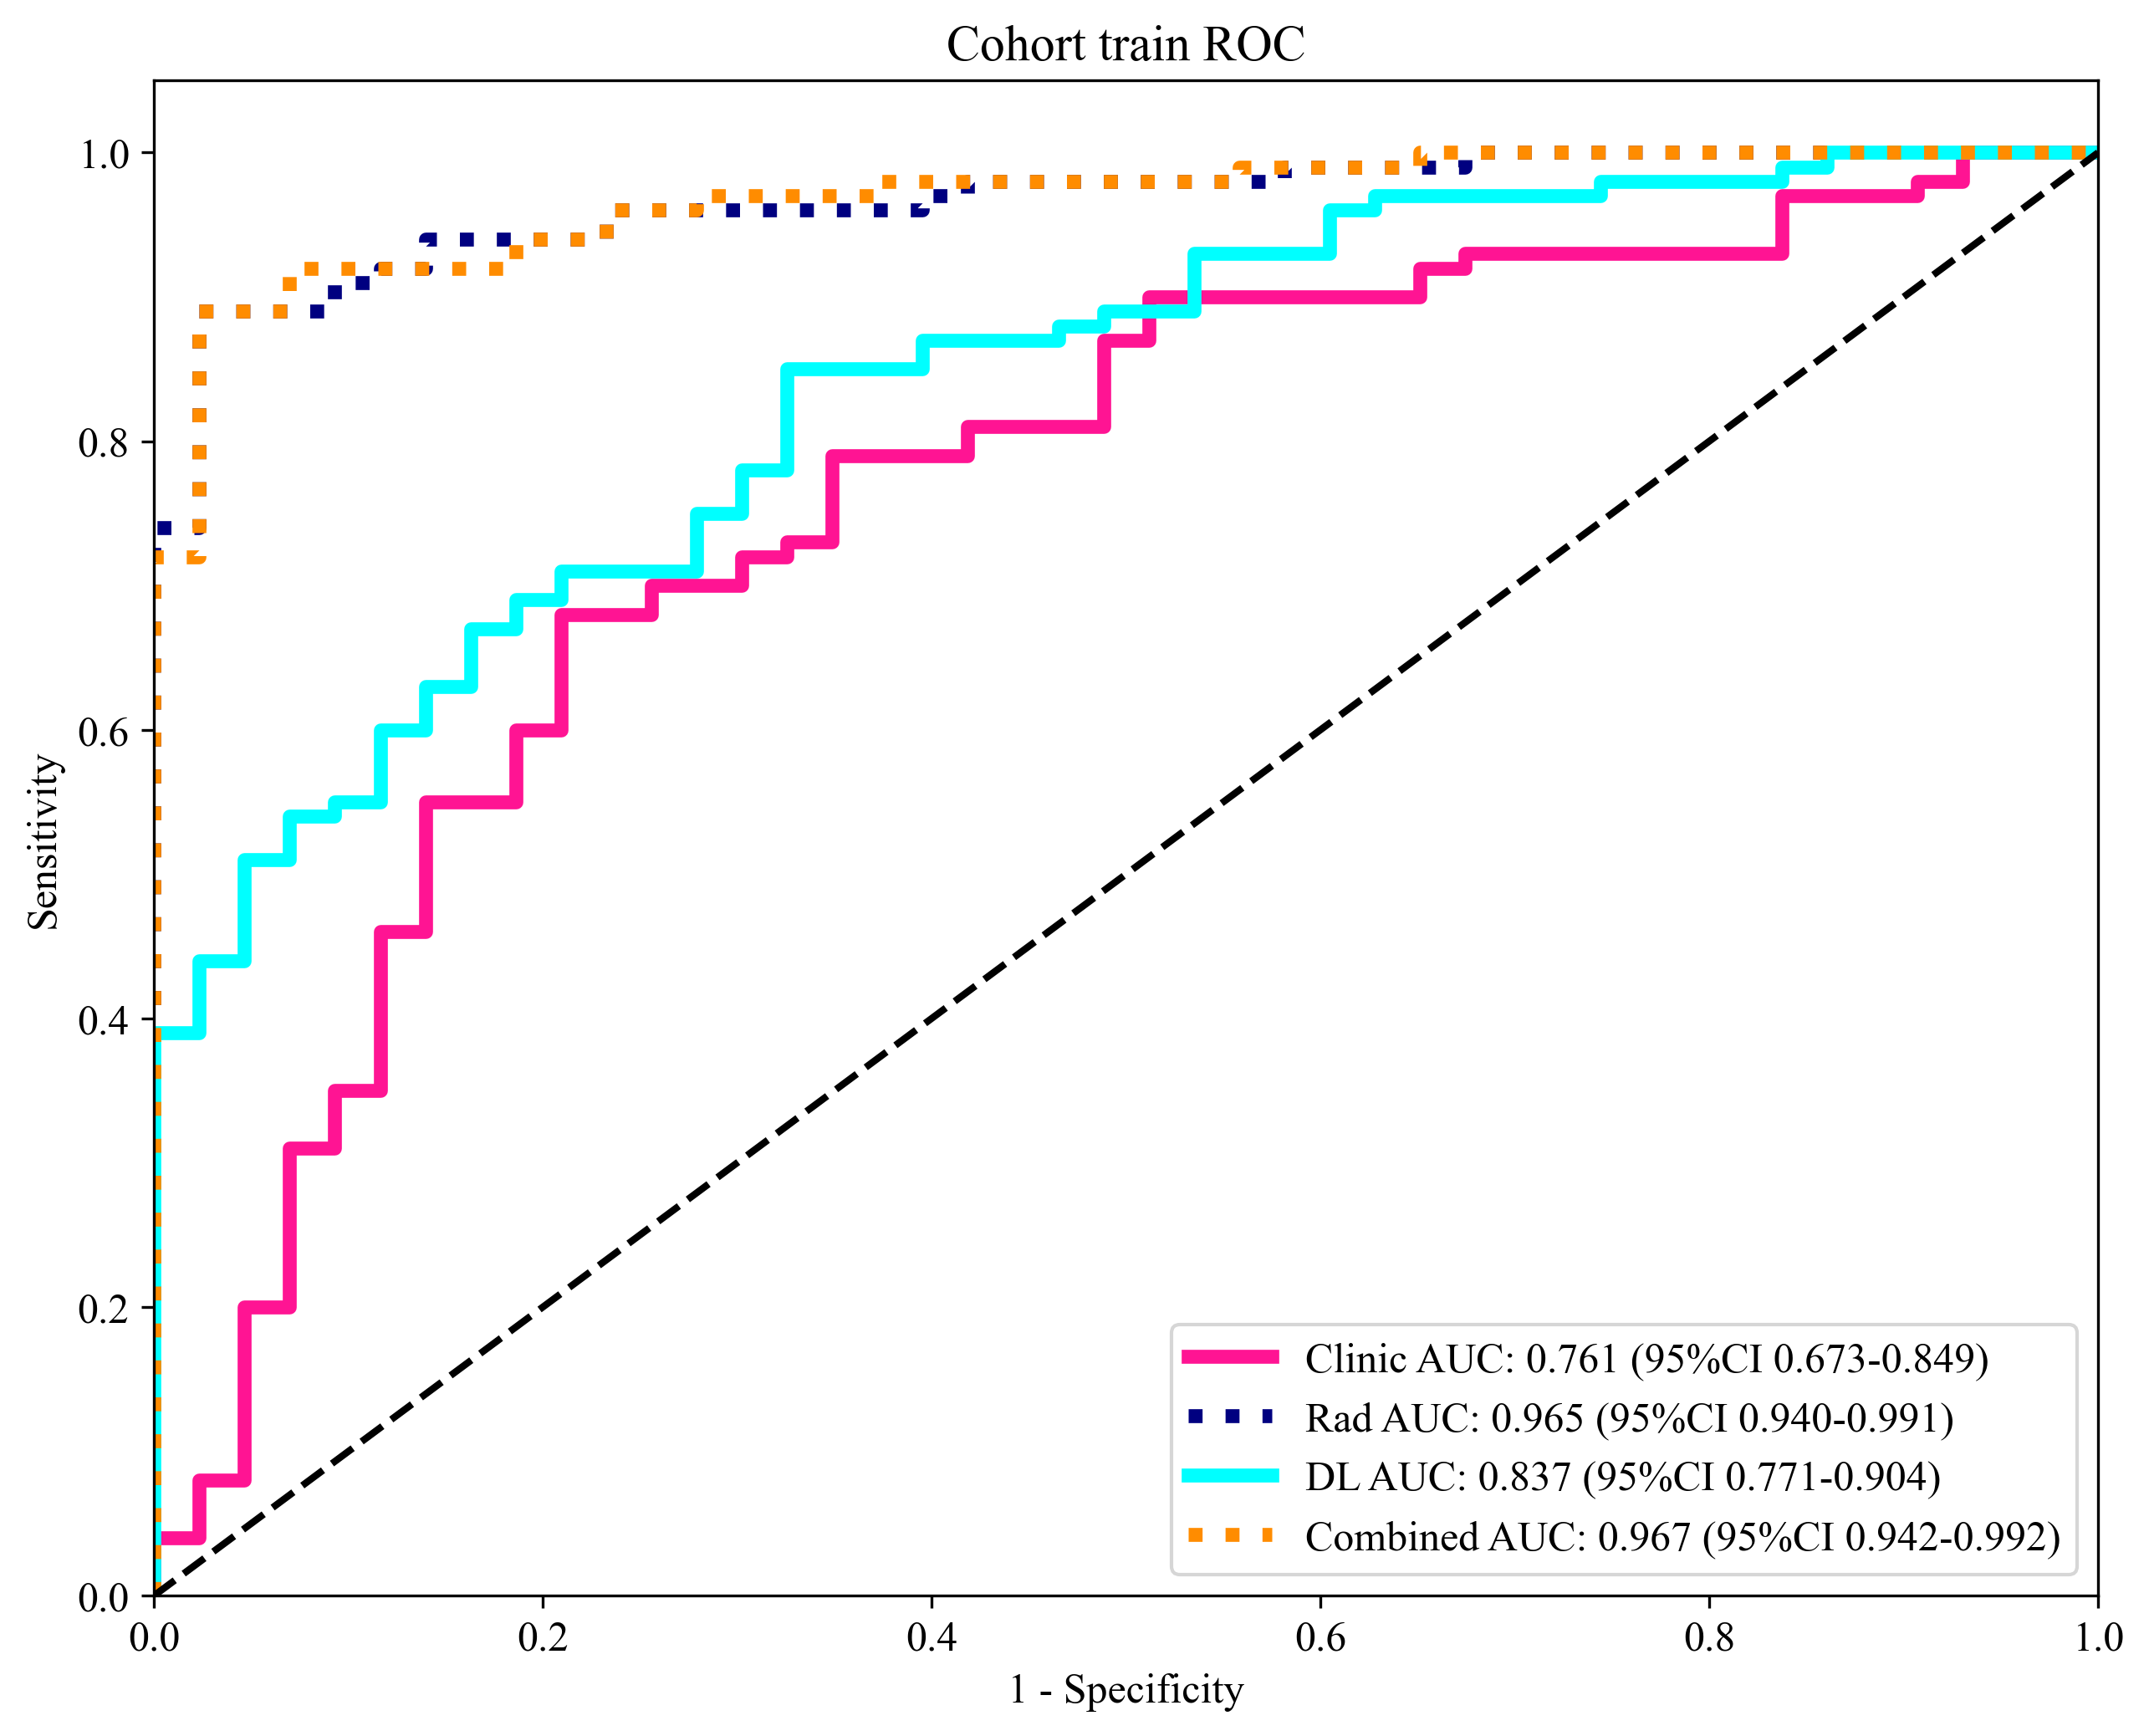

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,Clinic,0.713,0.761,0.6734 - 0.8494,0.68,0.791,0.883,0.515,0.883,0.68,0.768,0.742,train
1,Rad,0.916,0.965,0.9395 - 0.9912,0.89,0.977,0.989,0.792,0.989,0.89,0.937,0.663,train
2,DL,0.797,0.837,0.7711 - 0.9038,0.85,0.674,0.859,0.659,0.859,0.85,0.854,0.648,train
3,Combined,0.916,0.967,0.9419 - 0.9921,0.89,0.977,0.989,0.792,0.989,0.89,0.937,0.735,train


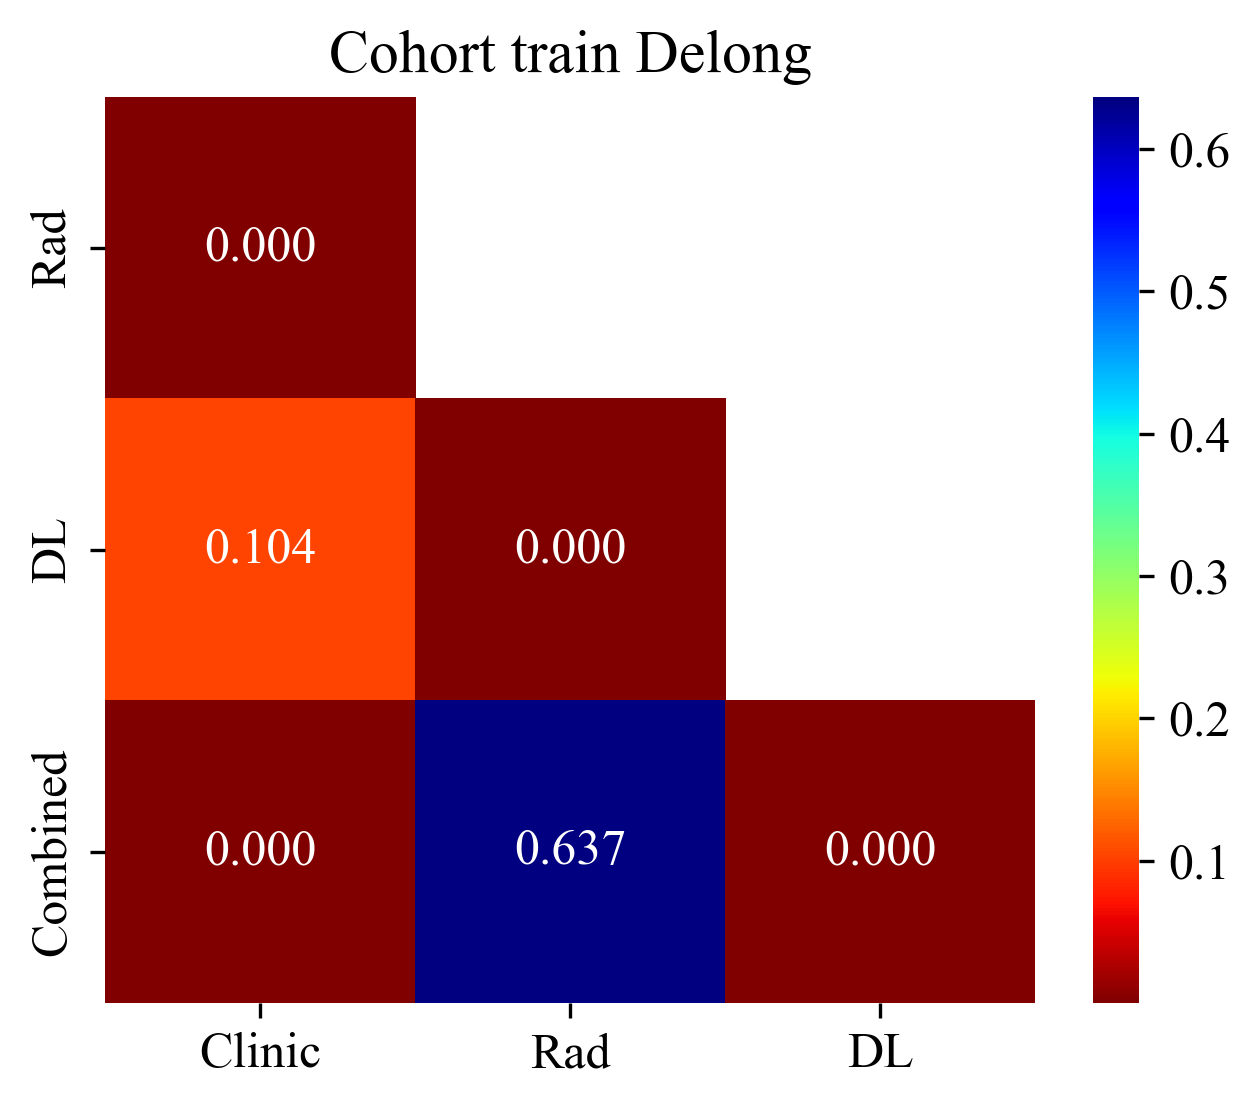

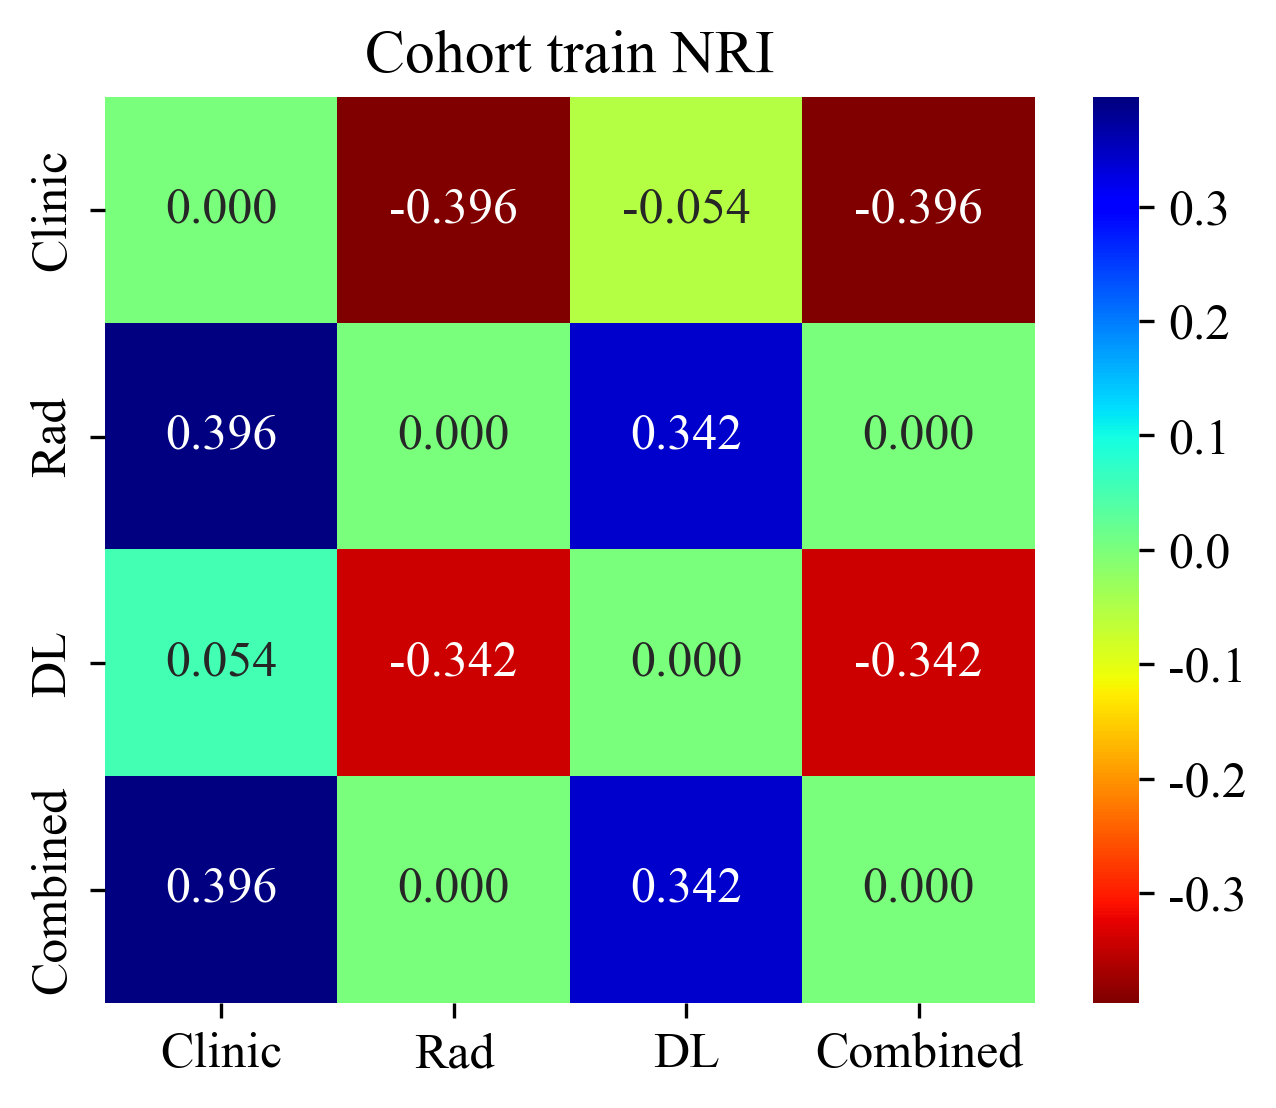

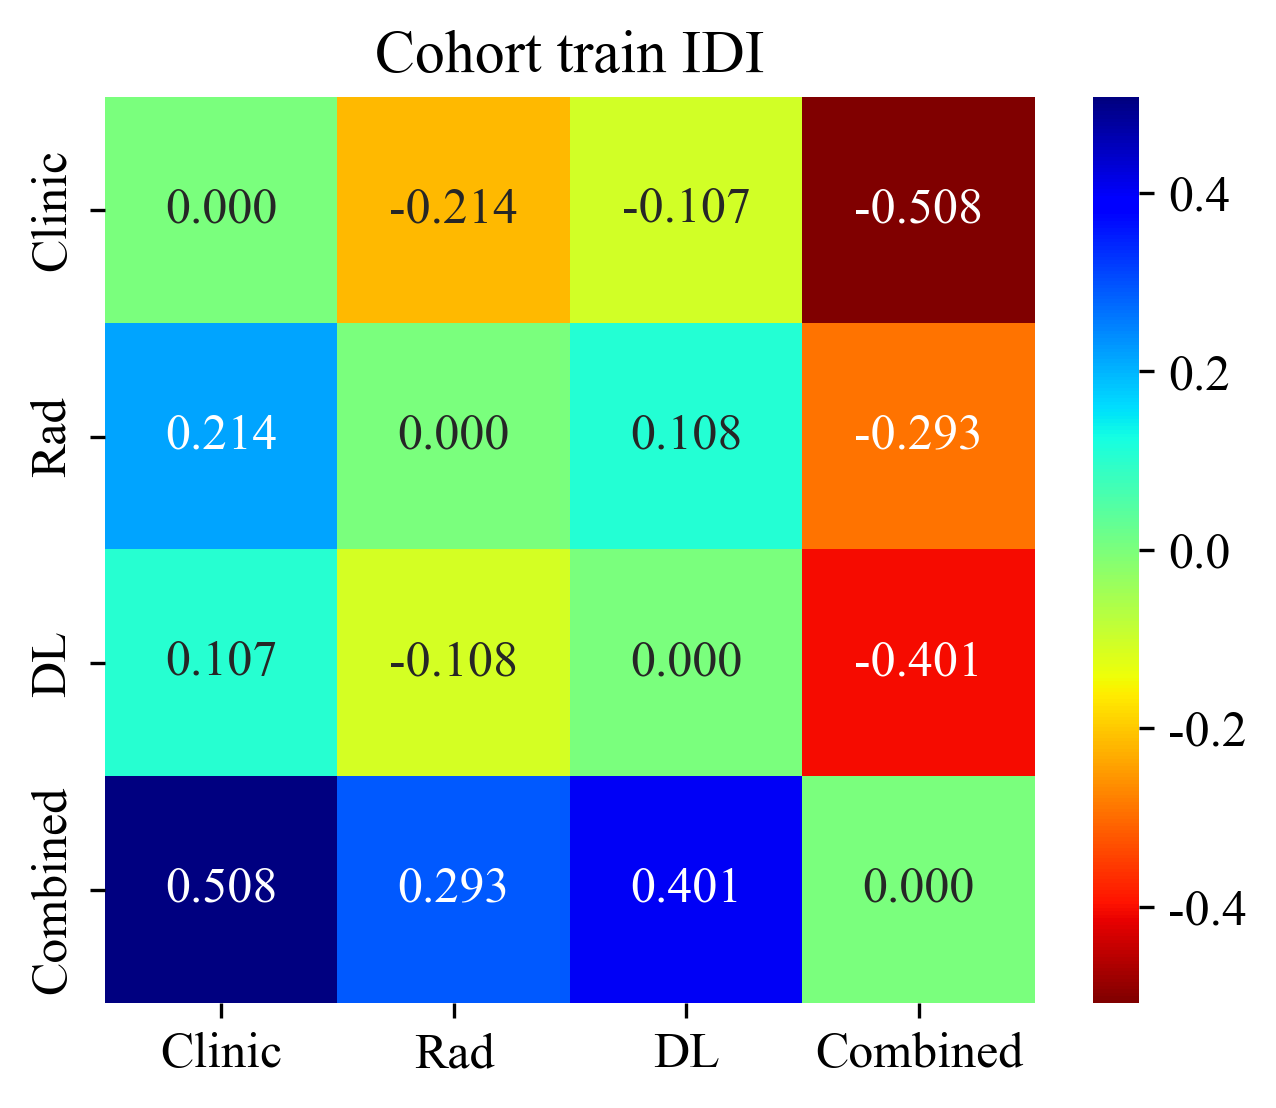

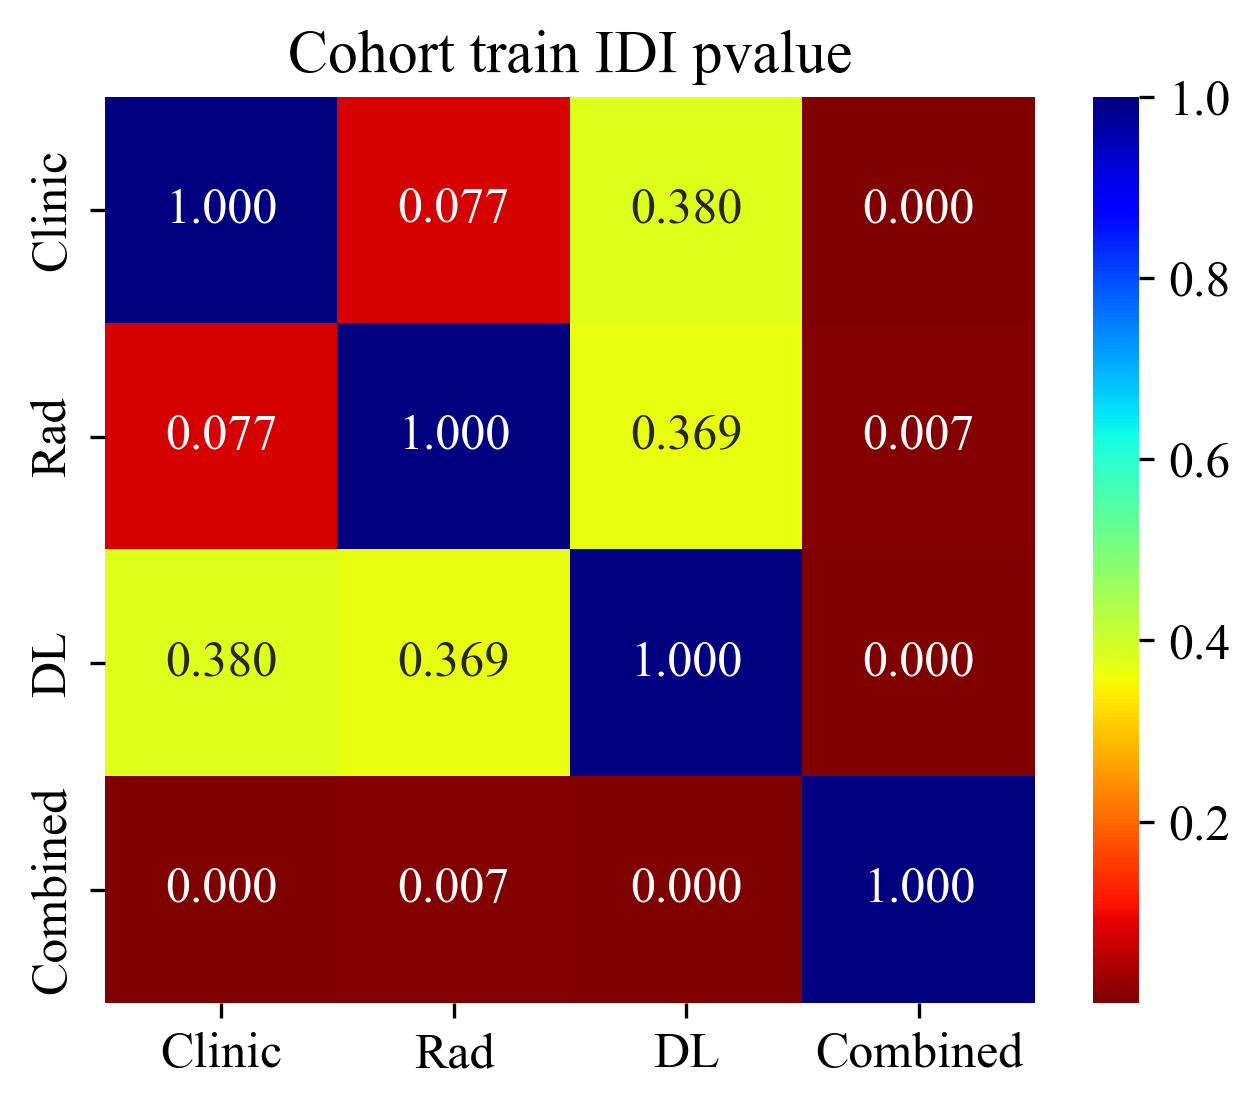

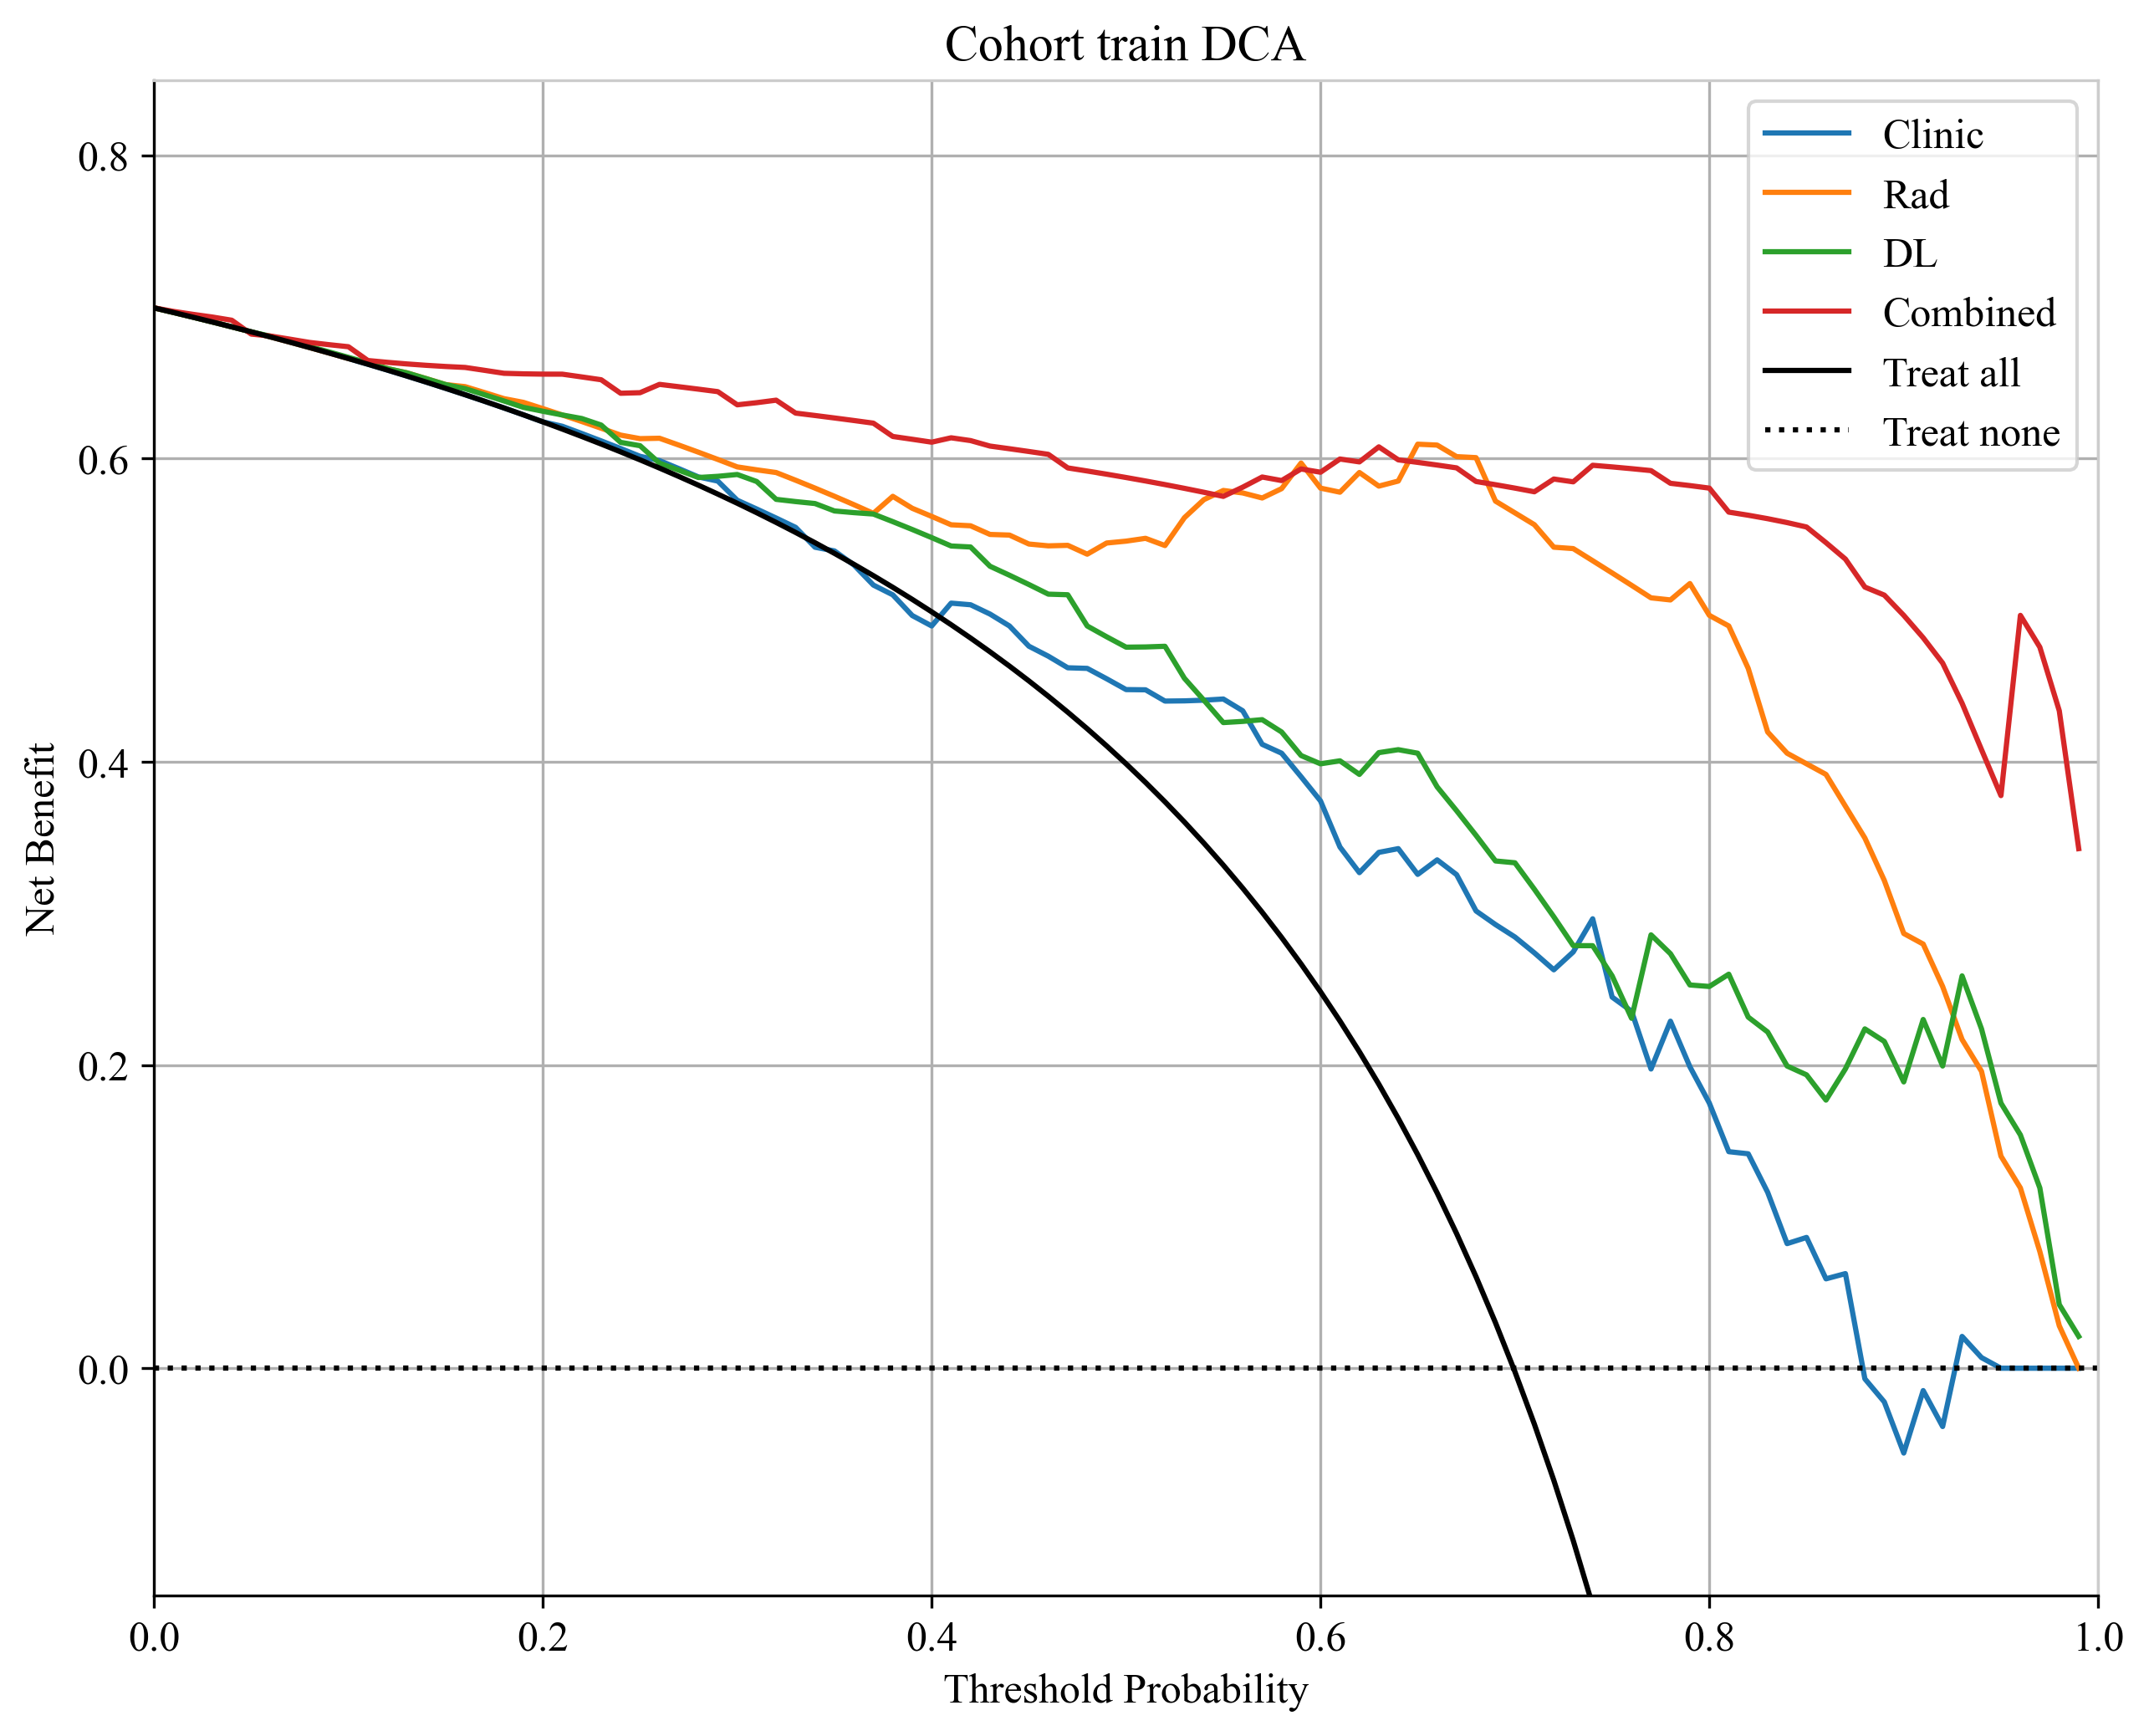

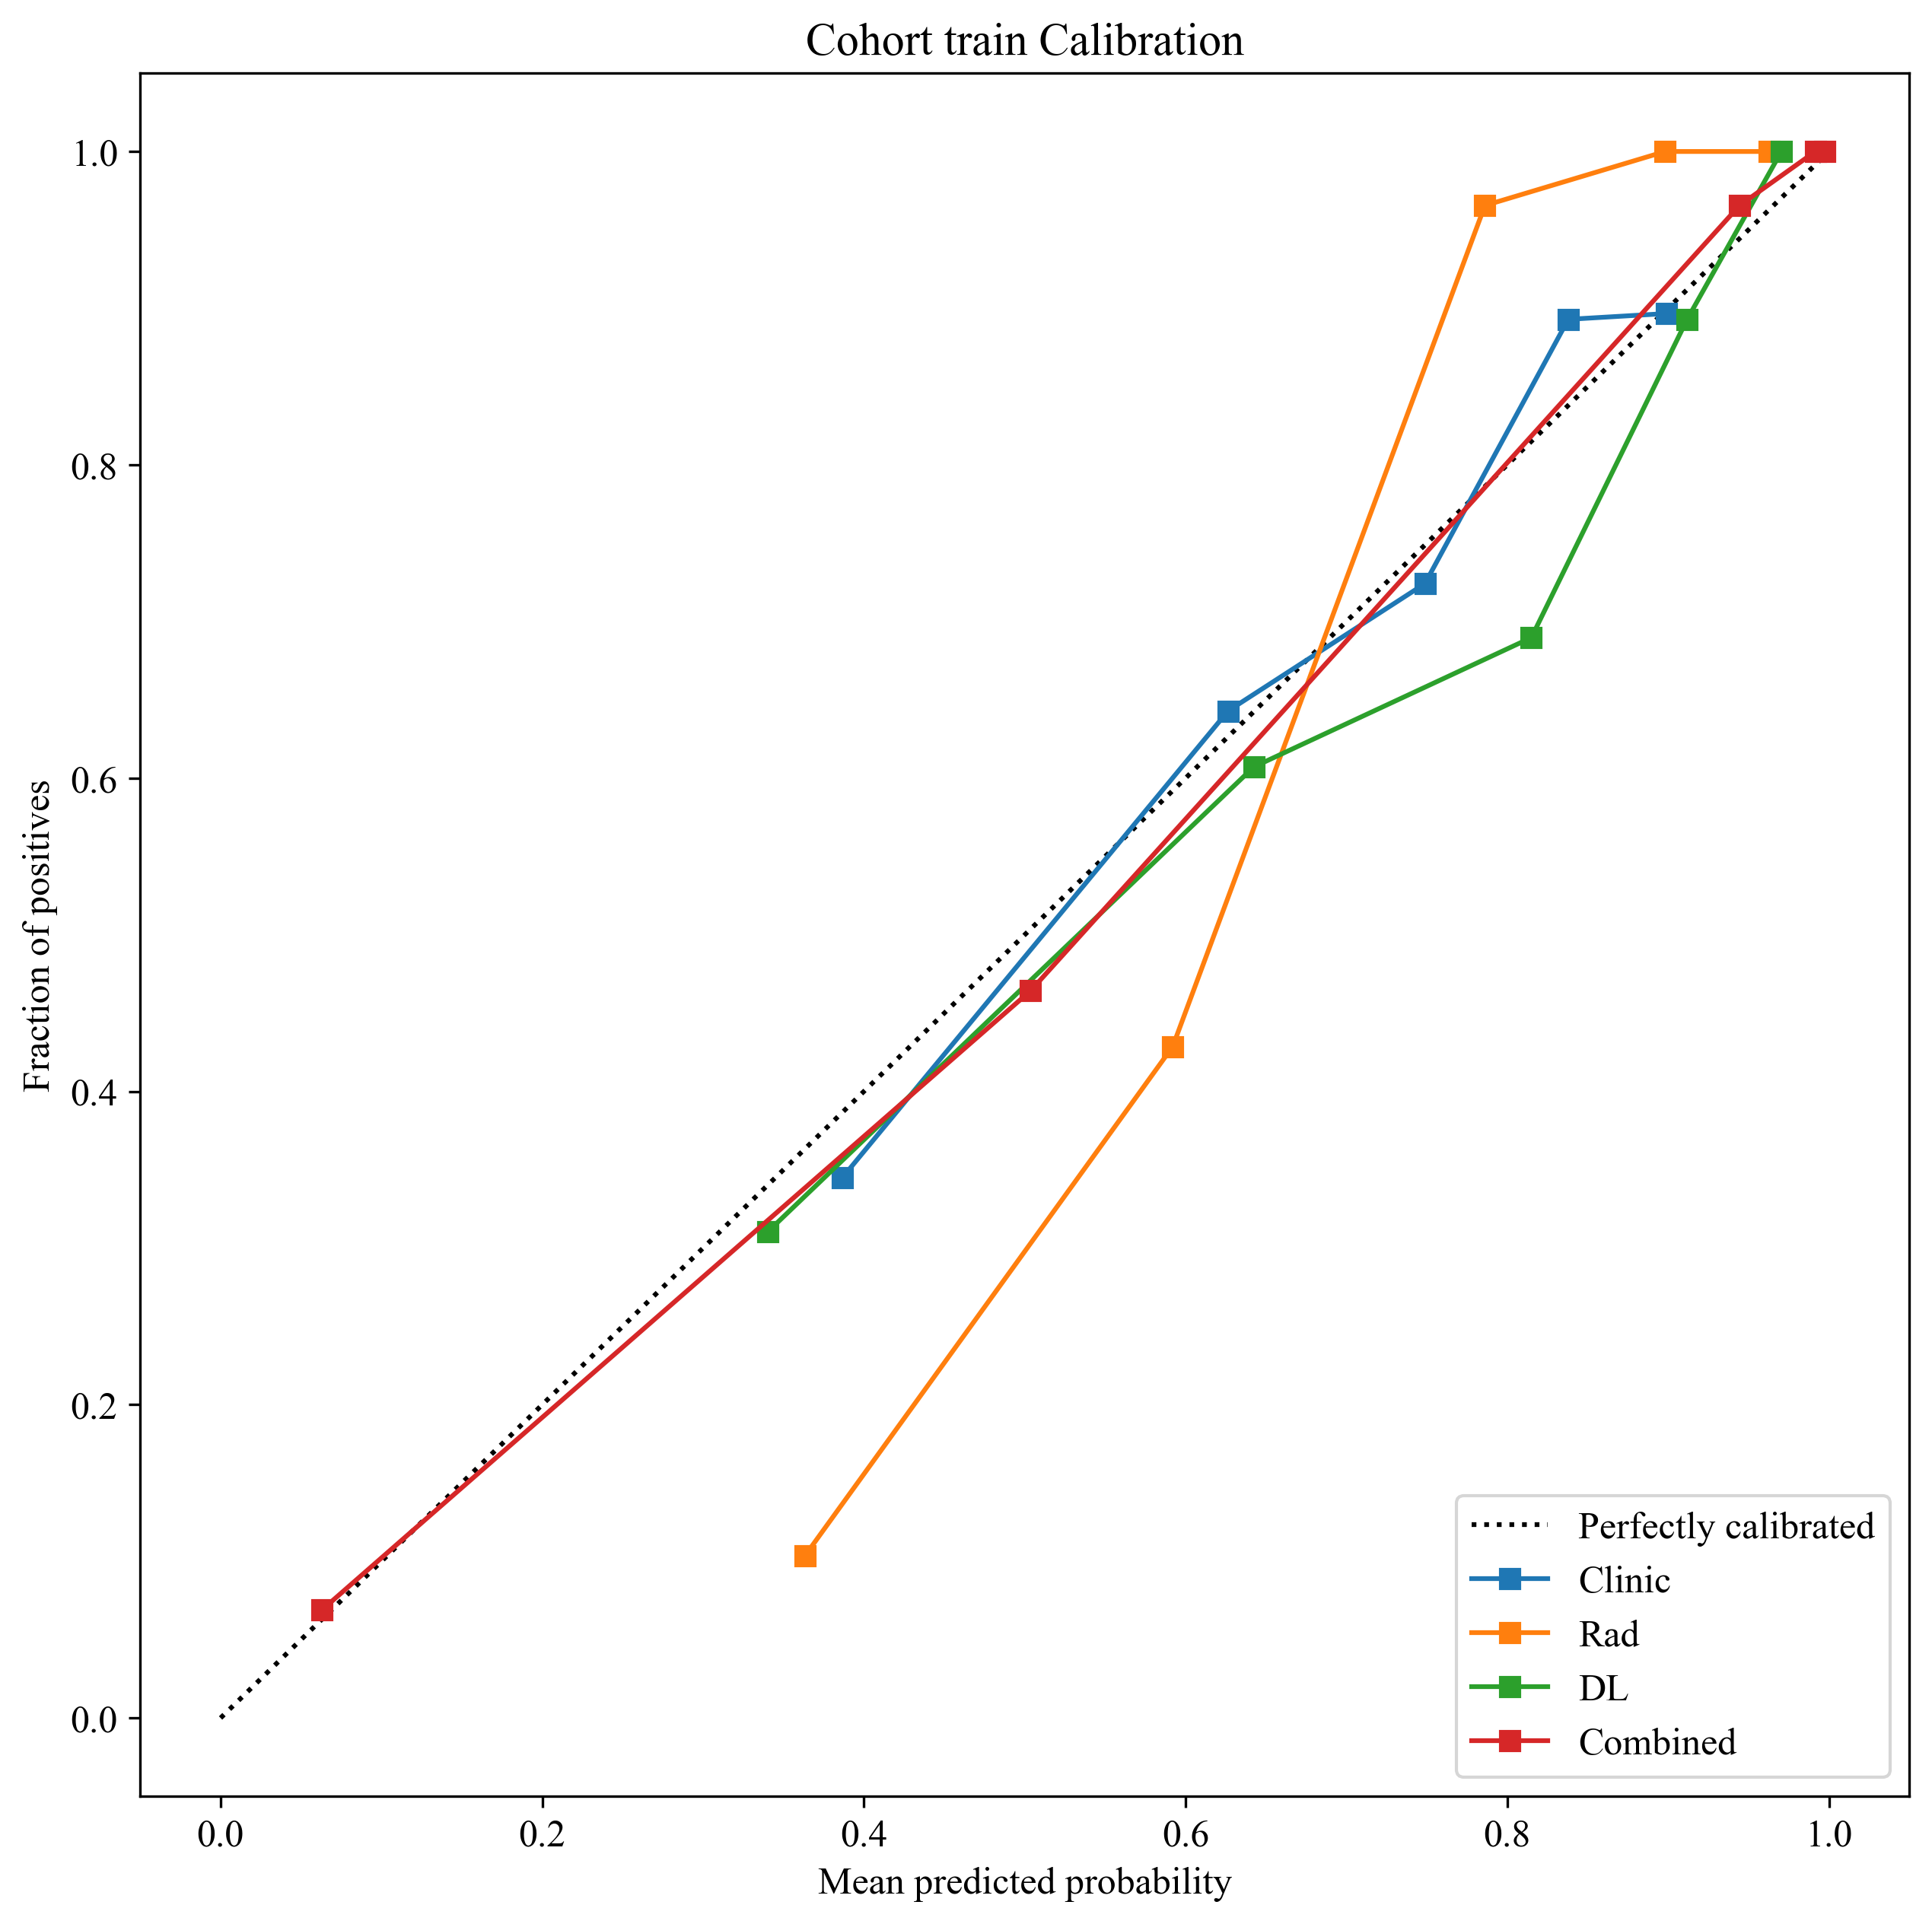

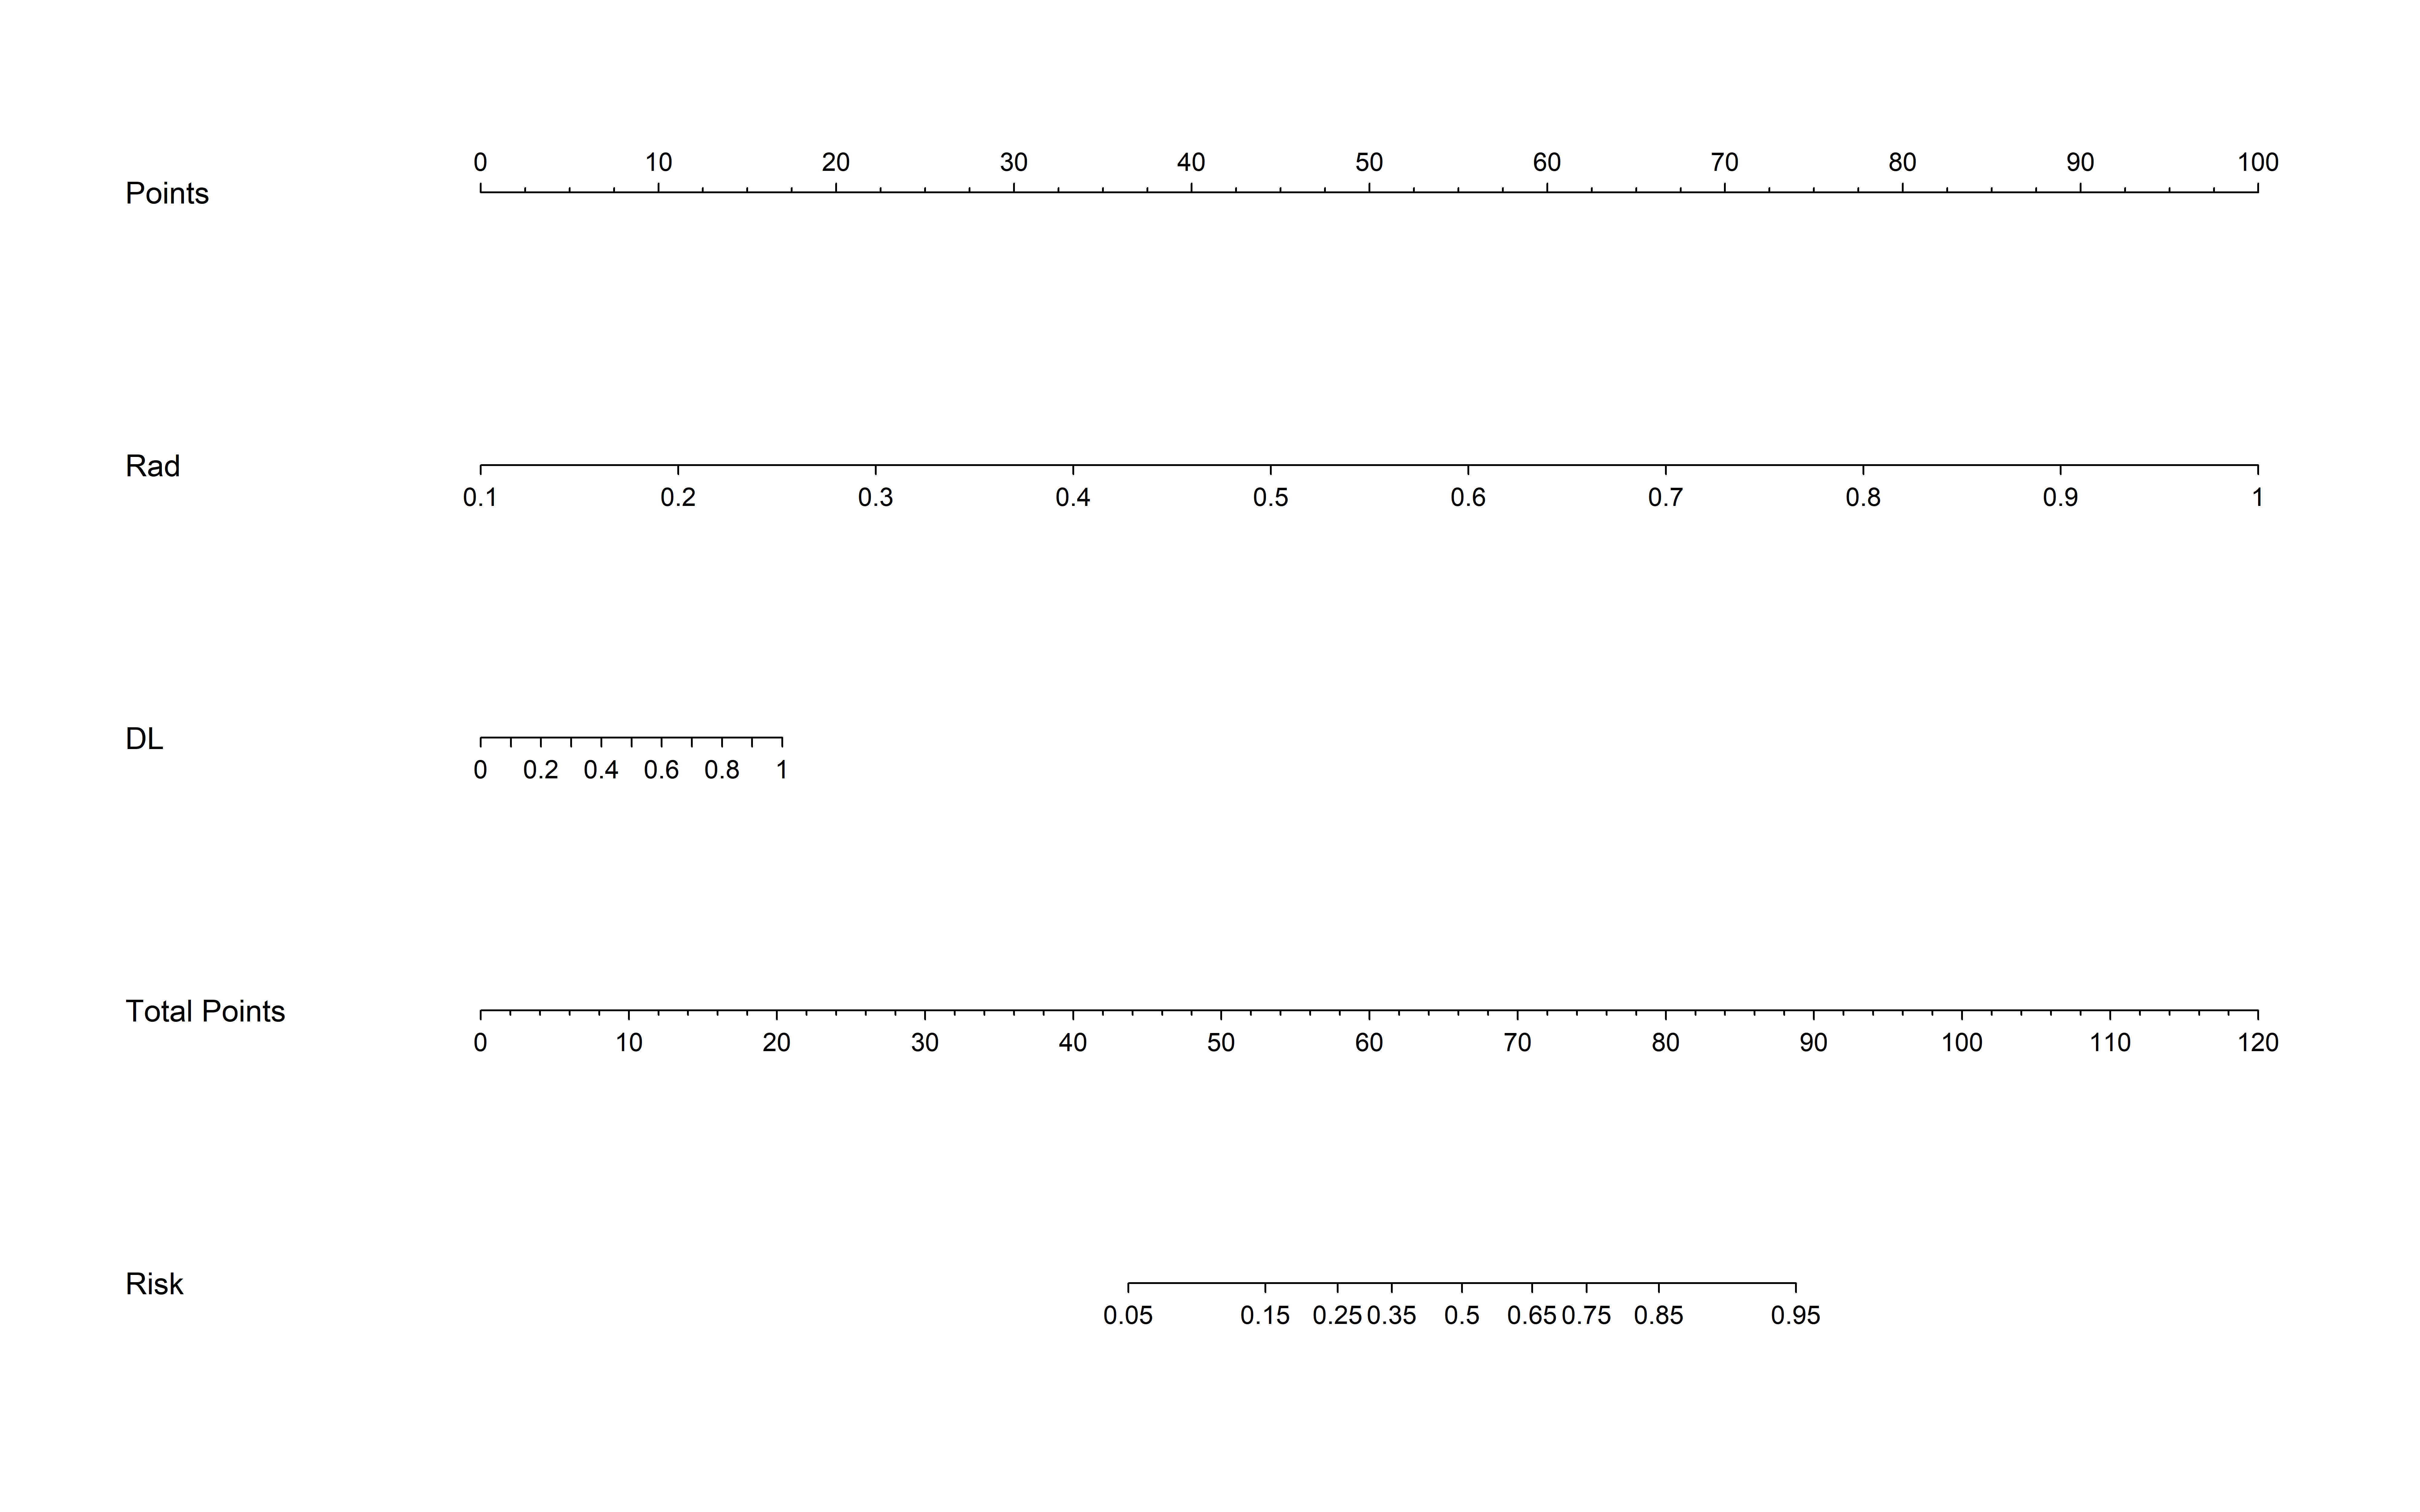

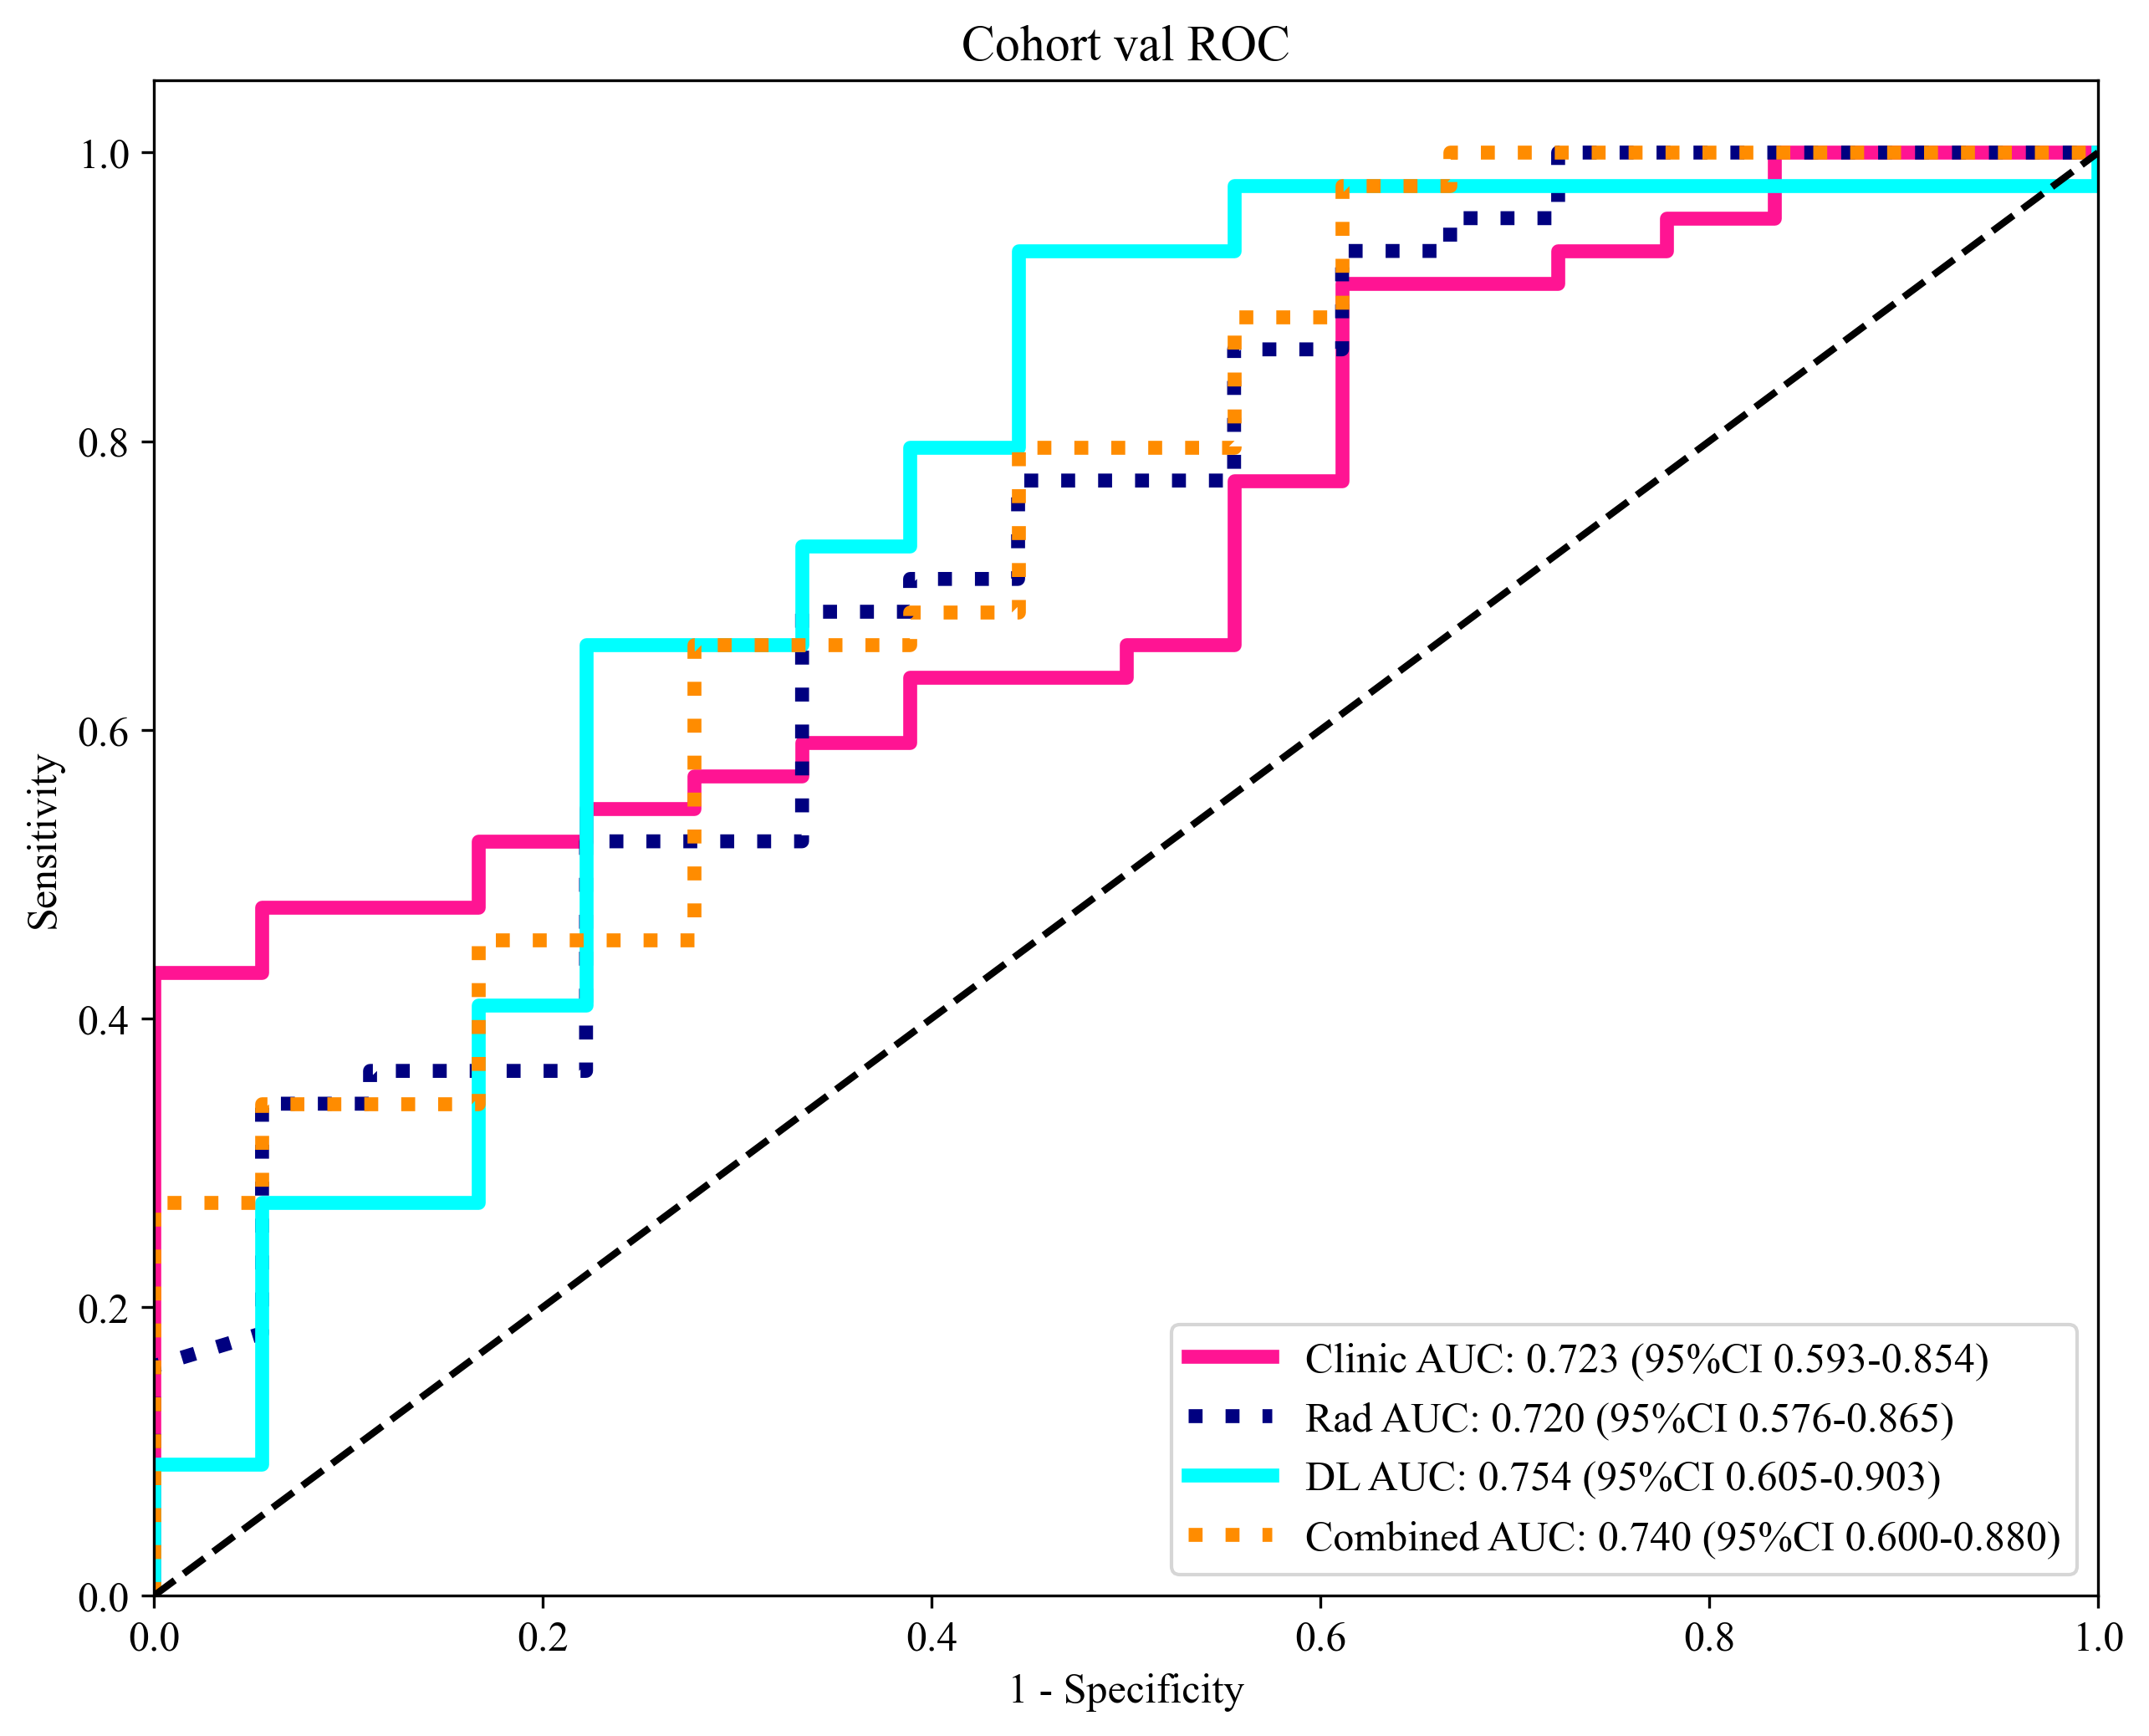

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,Clinic,0.713,0.761,0.6734 - 0.8494,0.680,0.791,0.883,0.515,0.883,0.680,0.768,0.742,train
1,Rad,0.916,0.965,0.9395 - 0.9912,0.890,0.977,0.989,0.792,0.989,0.890,0.937,0.663,train
2,DL,0.797,0.837,0.7711 - 0.9038,0.850,0.674,0.859,0.659,0.859,0.850,0.854,0.648,train
3,Combined,0.916,0.967,0.9419 - 0.9921,0.890,0.977,0.989,0.792,0.989,0.890,0.937,0.735,train
4,Clinic,0.597,0.723,0.5933 - 0.8536,0.432,1.000,1.000,0.419,1.000,0.432,0.603,0.824,val
5,Rad,0.677,0.720,0.5755 - 0.8651,0.682,0.667,0.833,0.462,0.833,0.682,0.750,0.749,val
6,DL,0.823,0.754,0.6046 - 0.9030,0.932,0.556,0.837,0.769,0.837,0.932,0.882,0.631,val
7,Combined,0.677,0.740,0.6000 - 0.8798,0.659,0.722,0.853,0.464,0.853,0.659,0.744,0.959,val


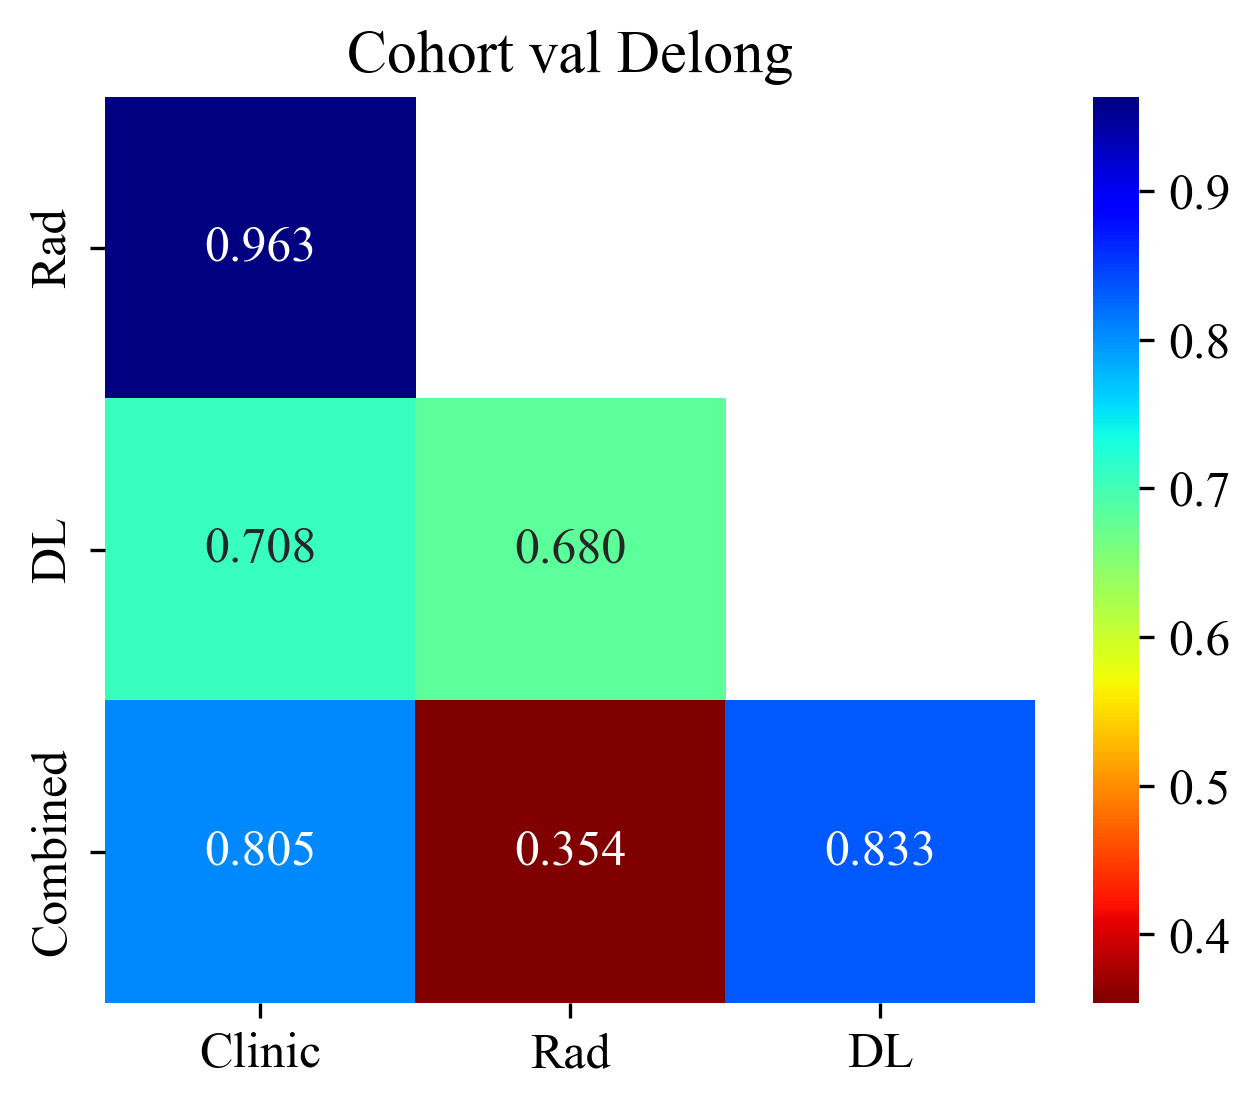

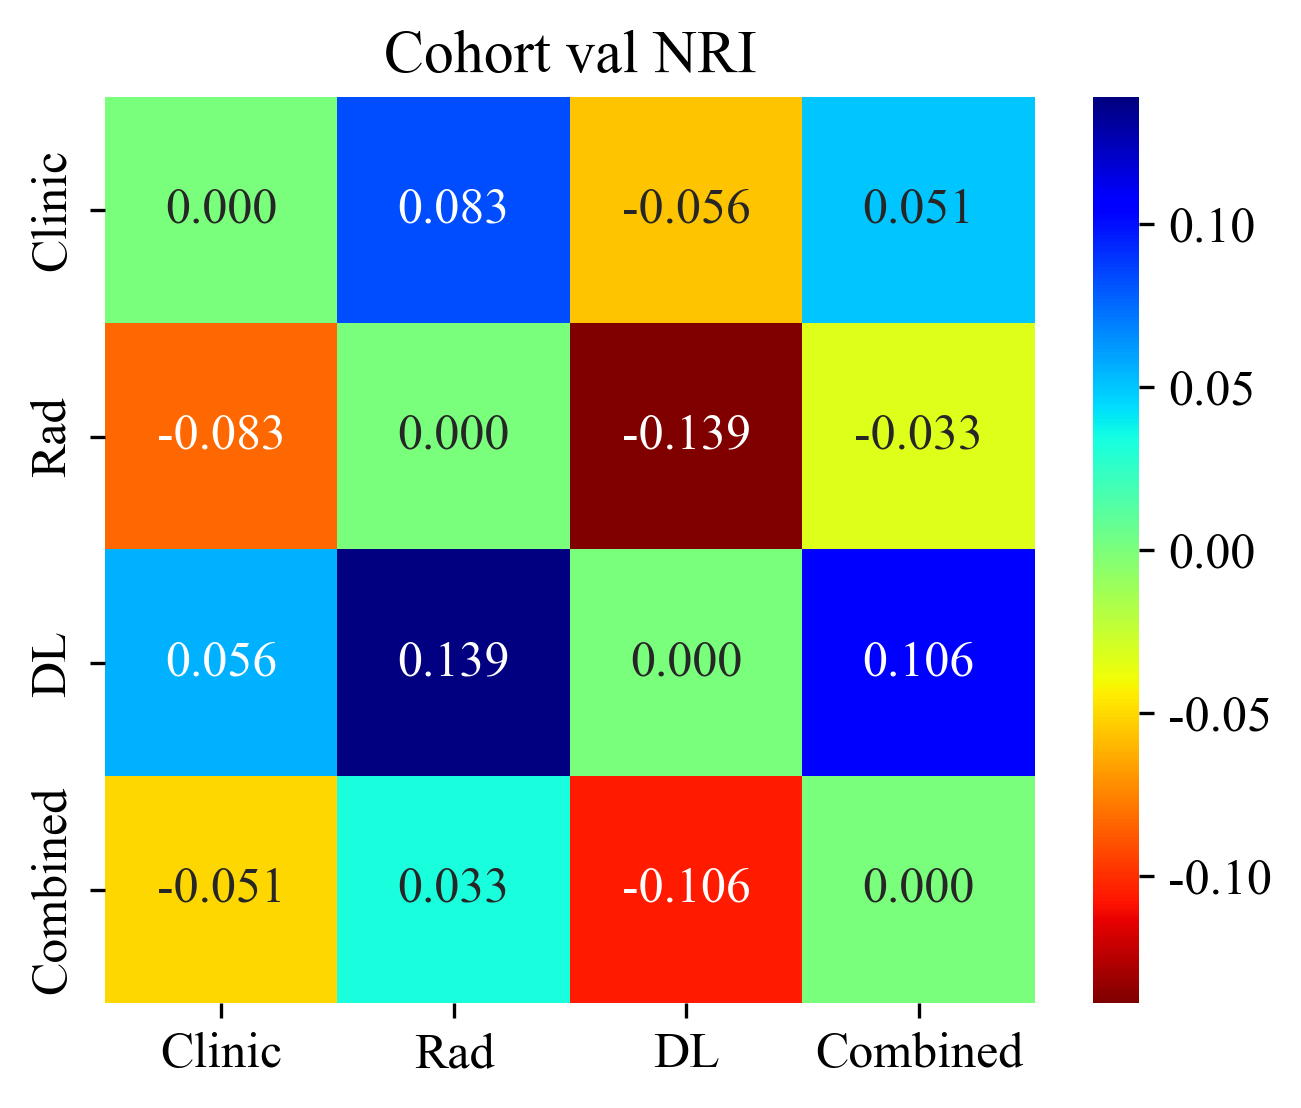

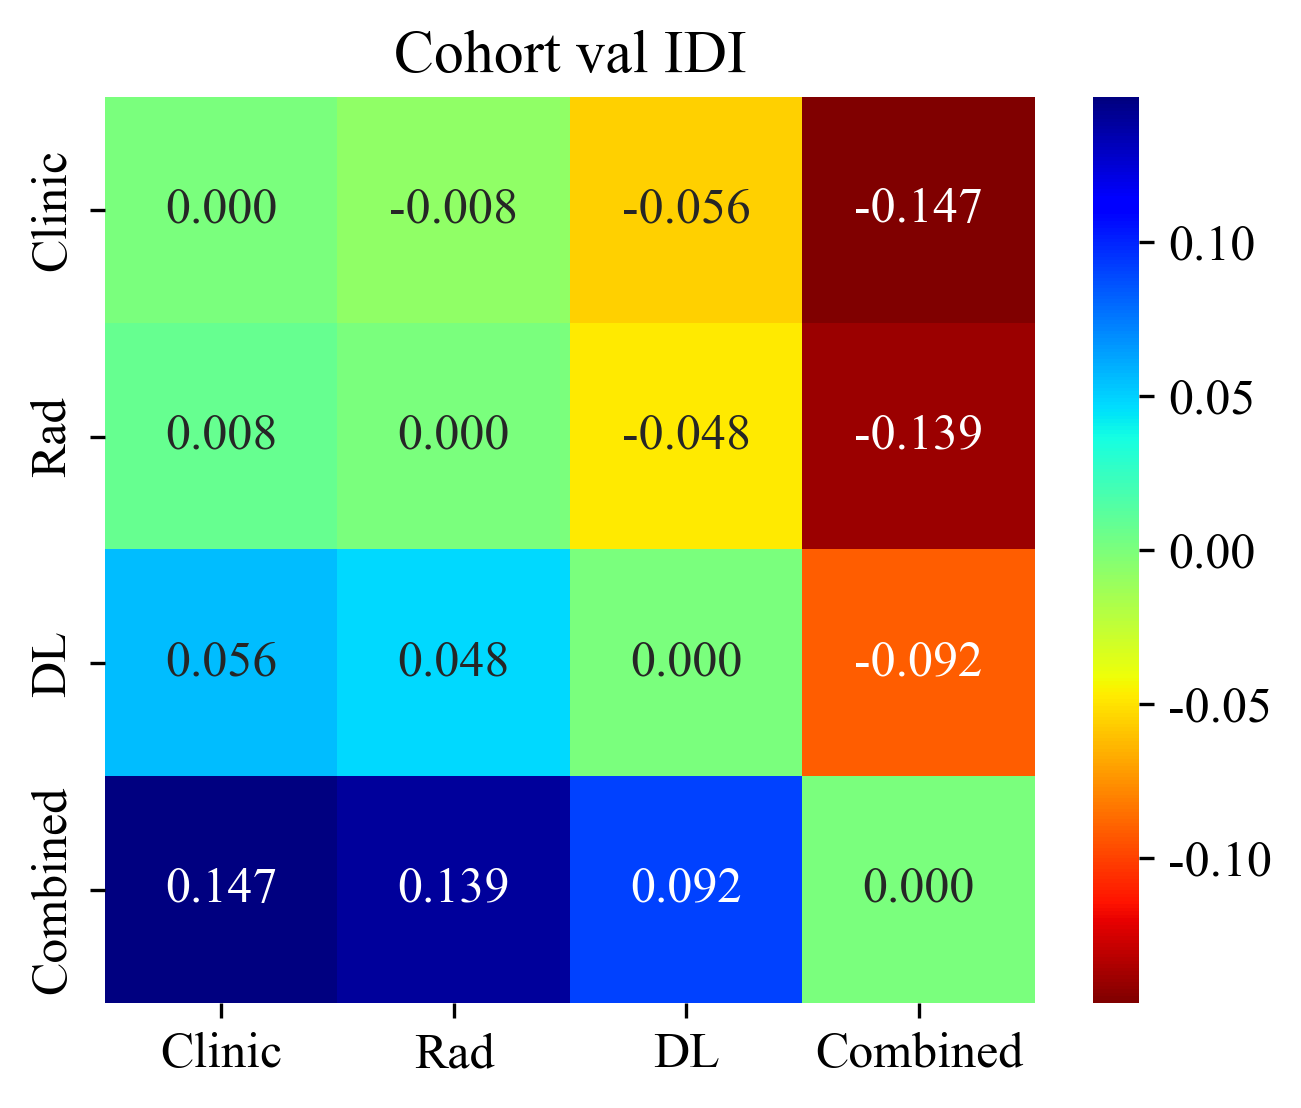

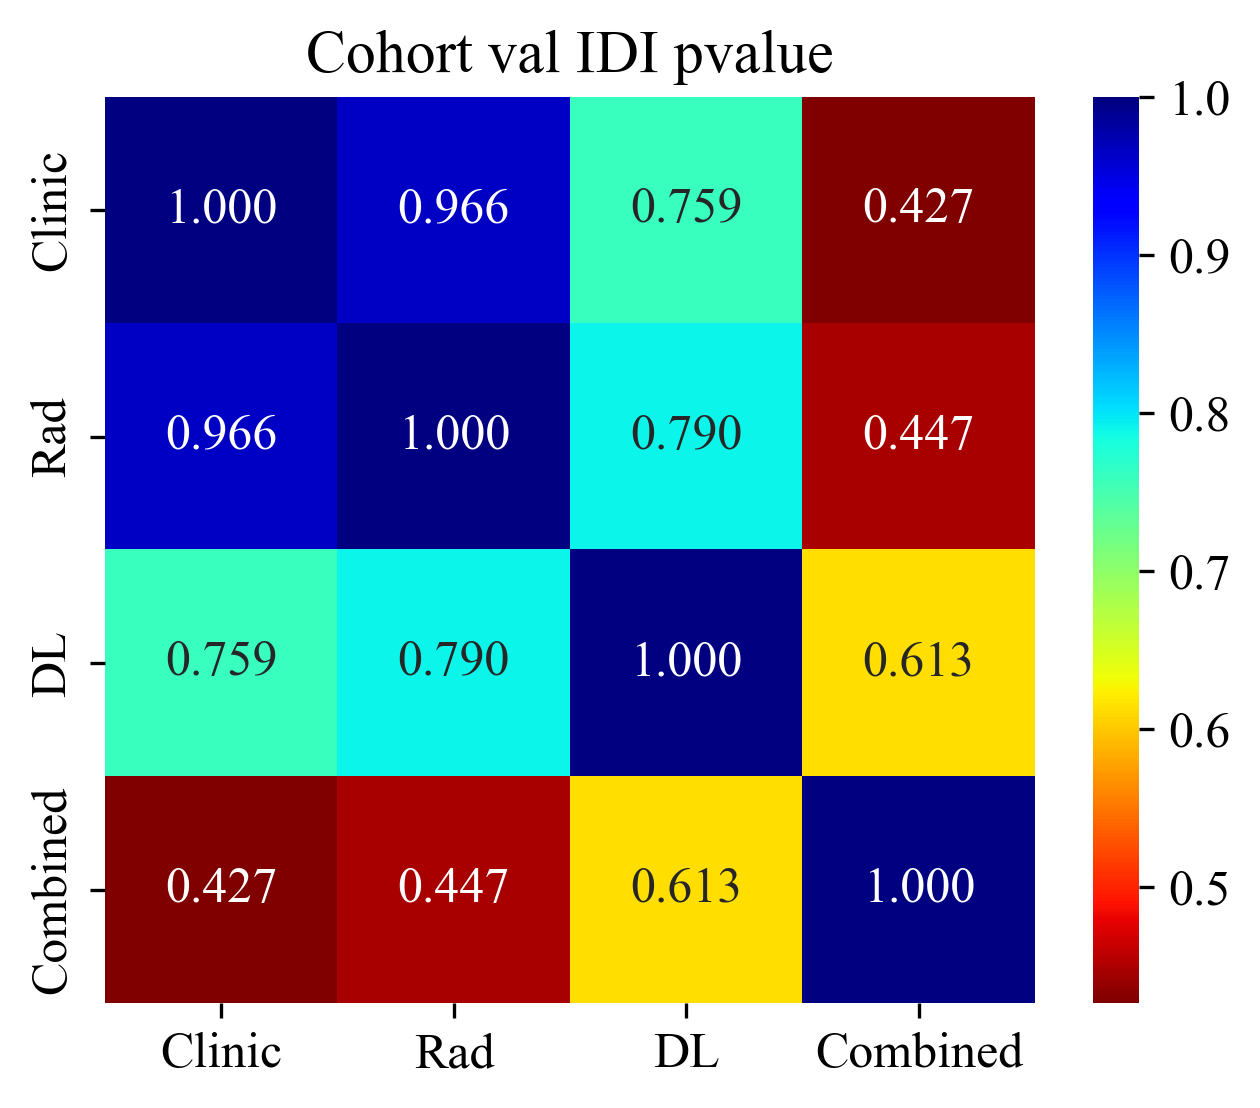

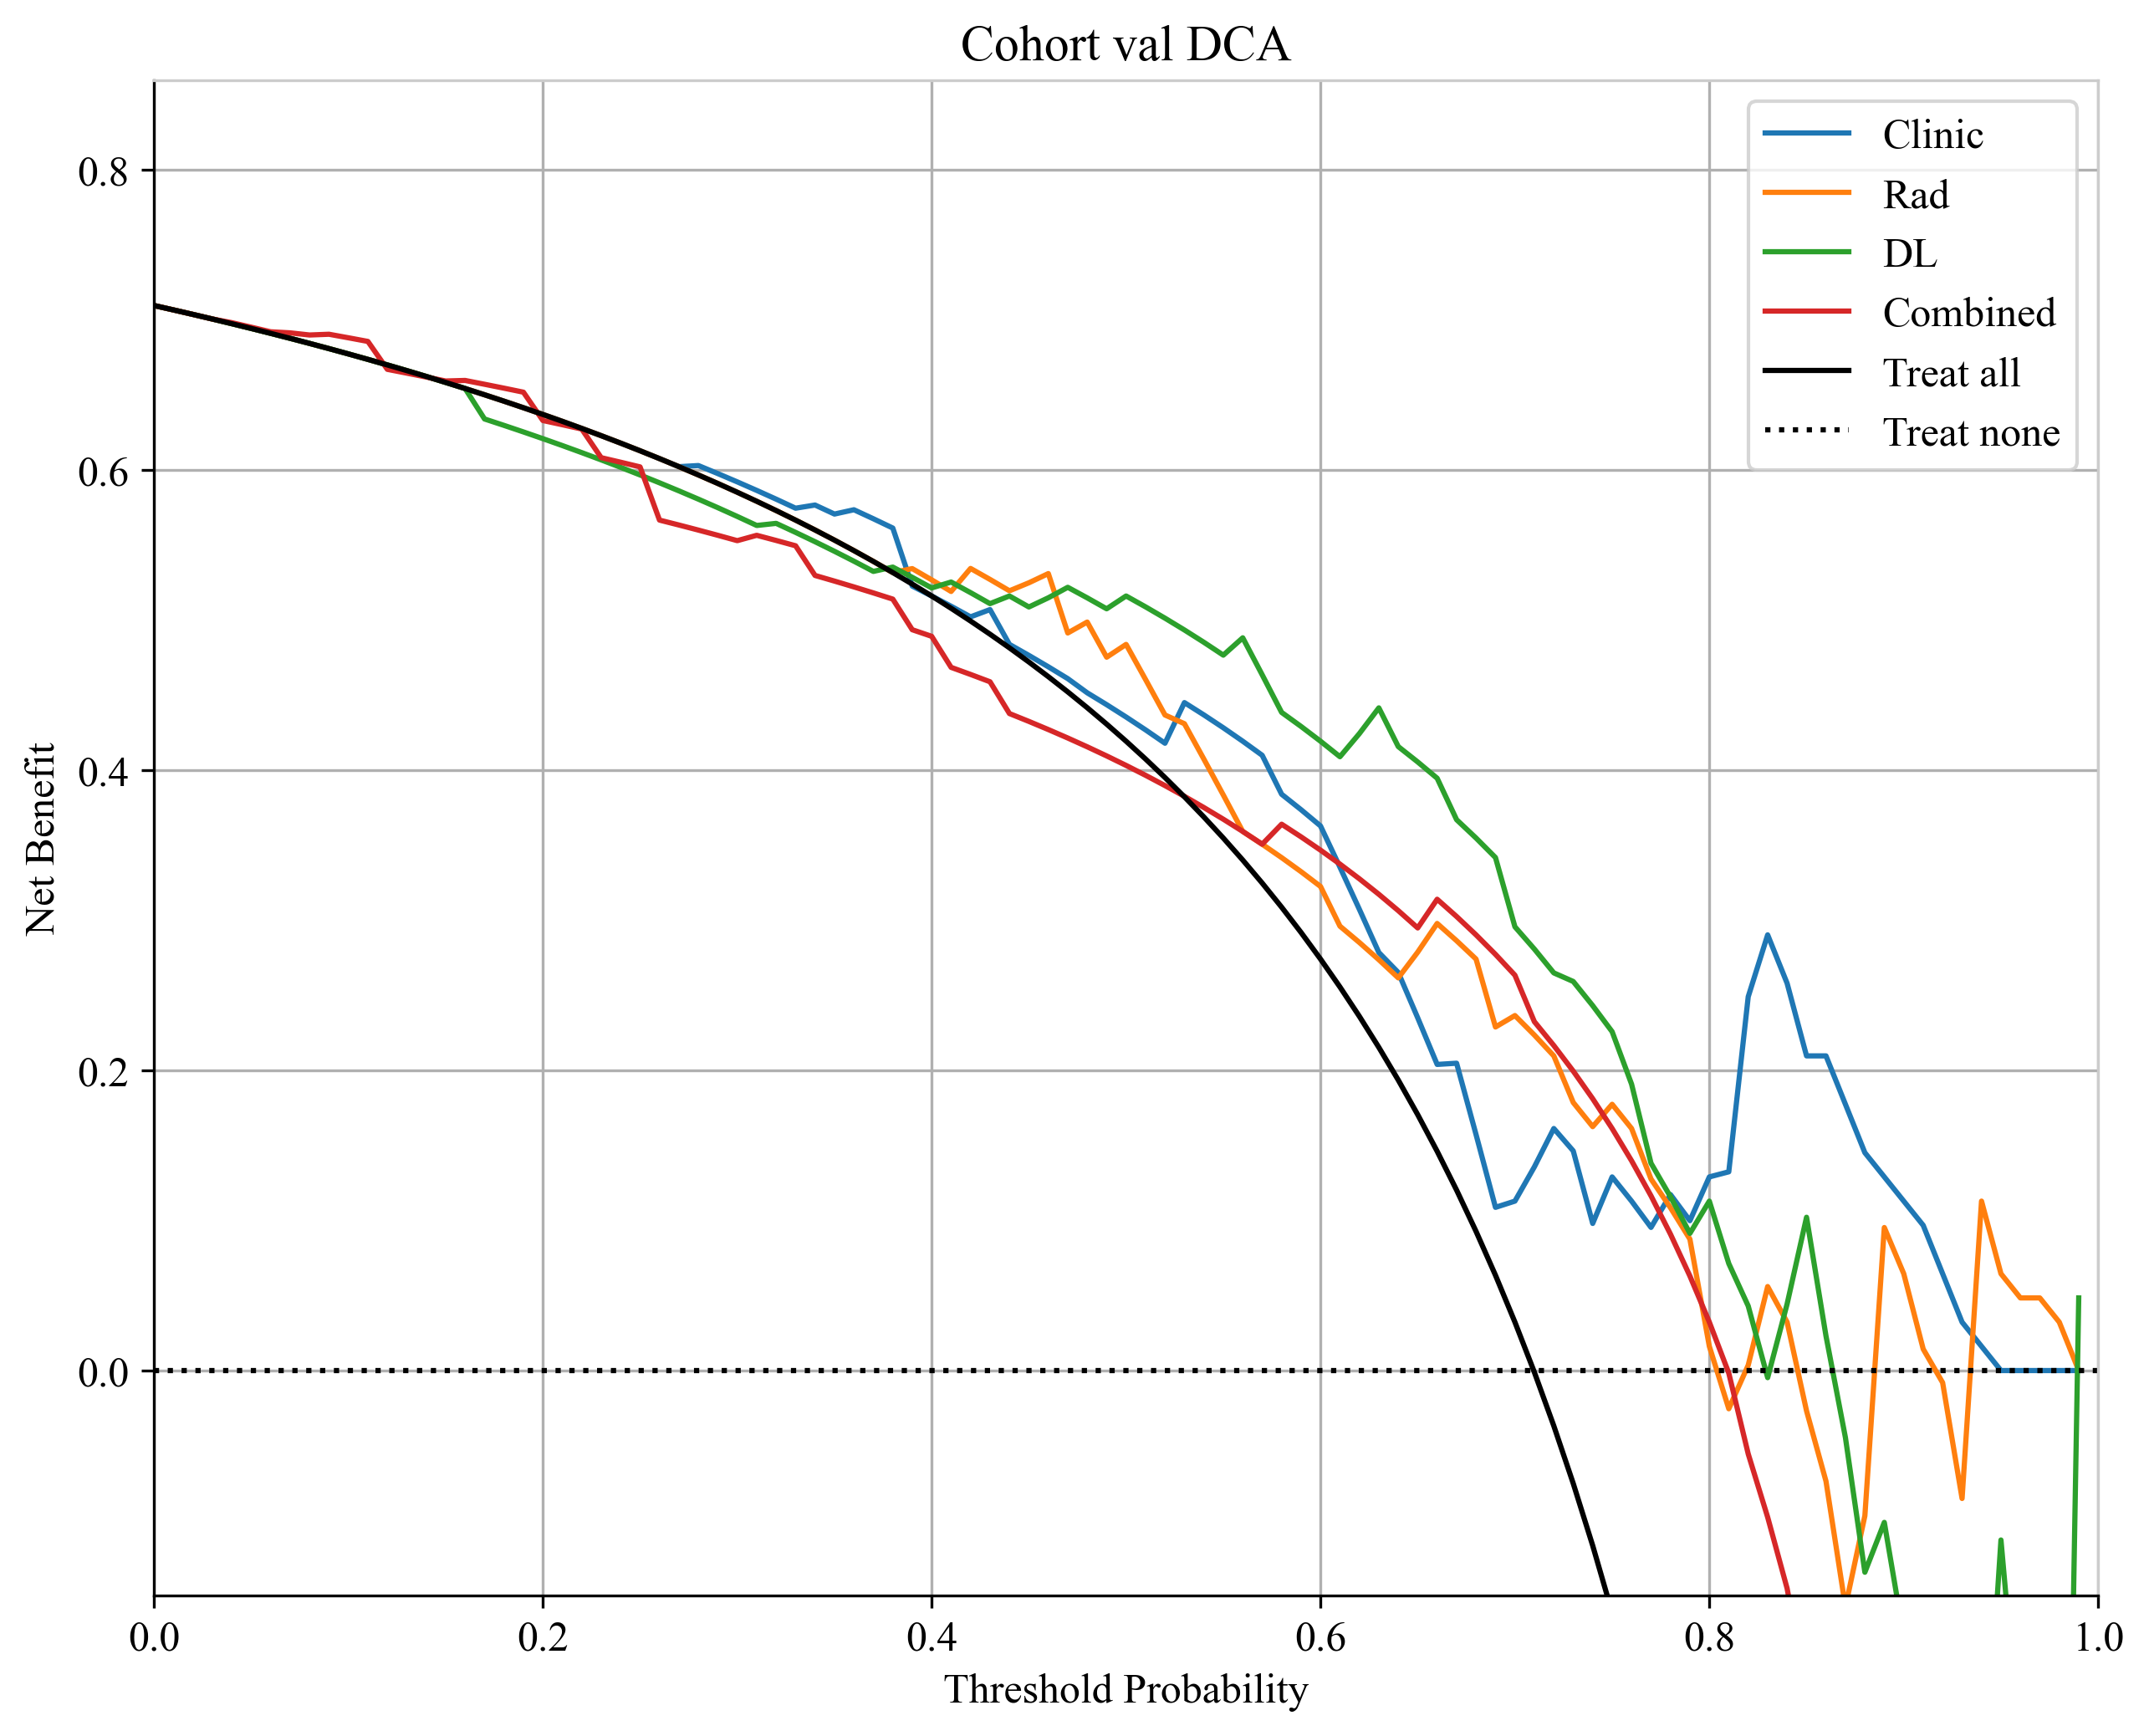

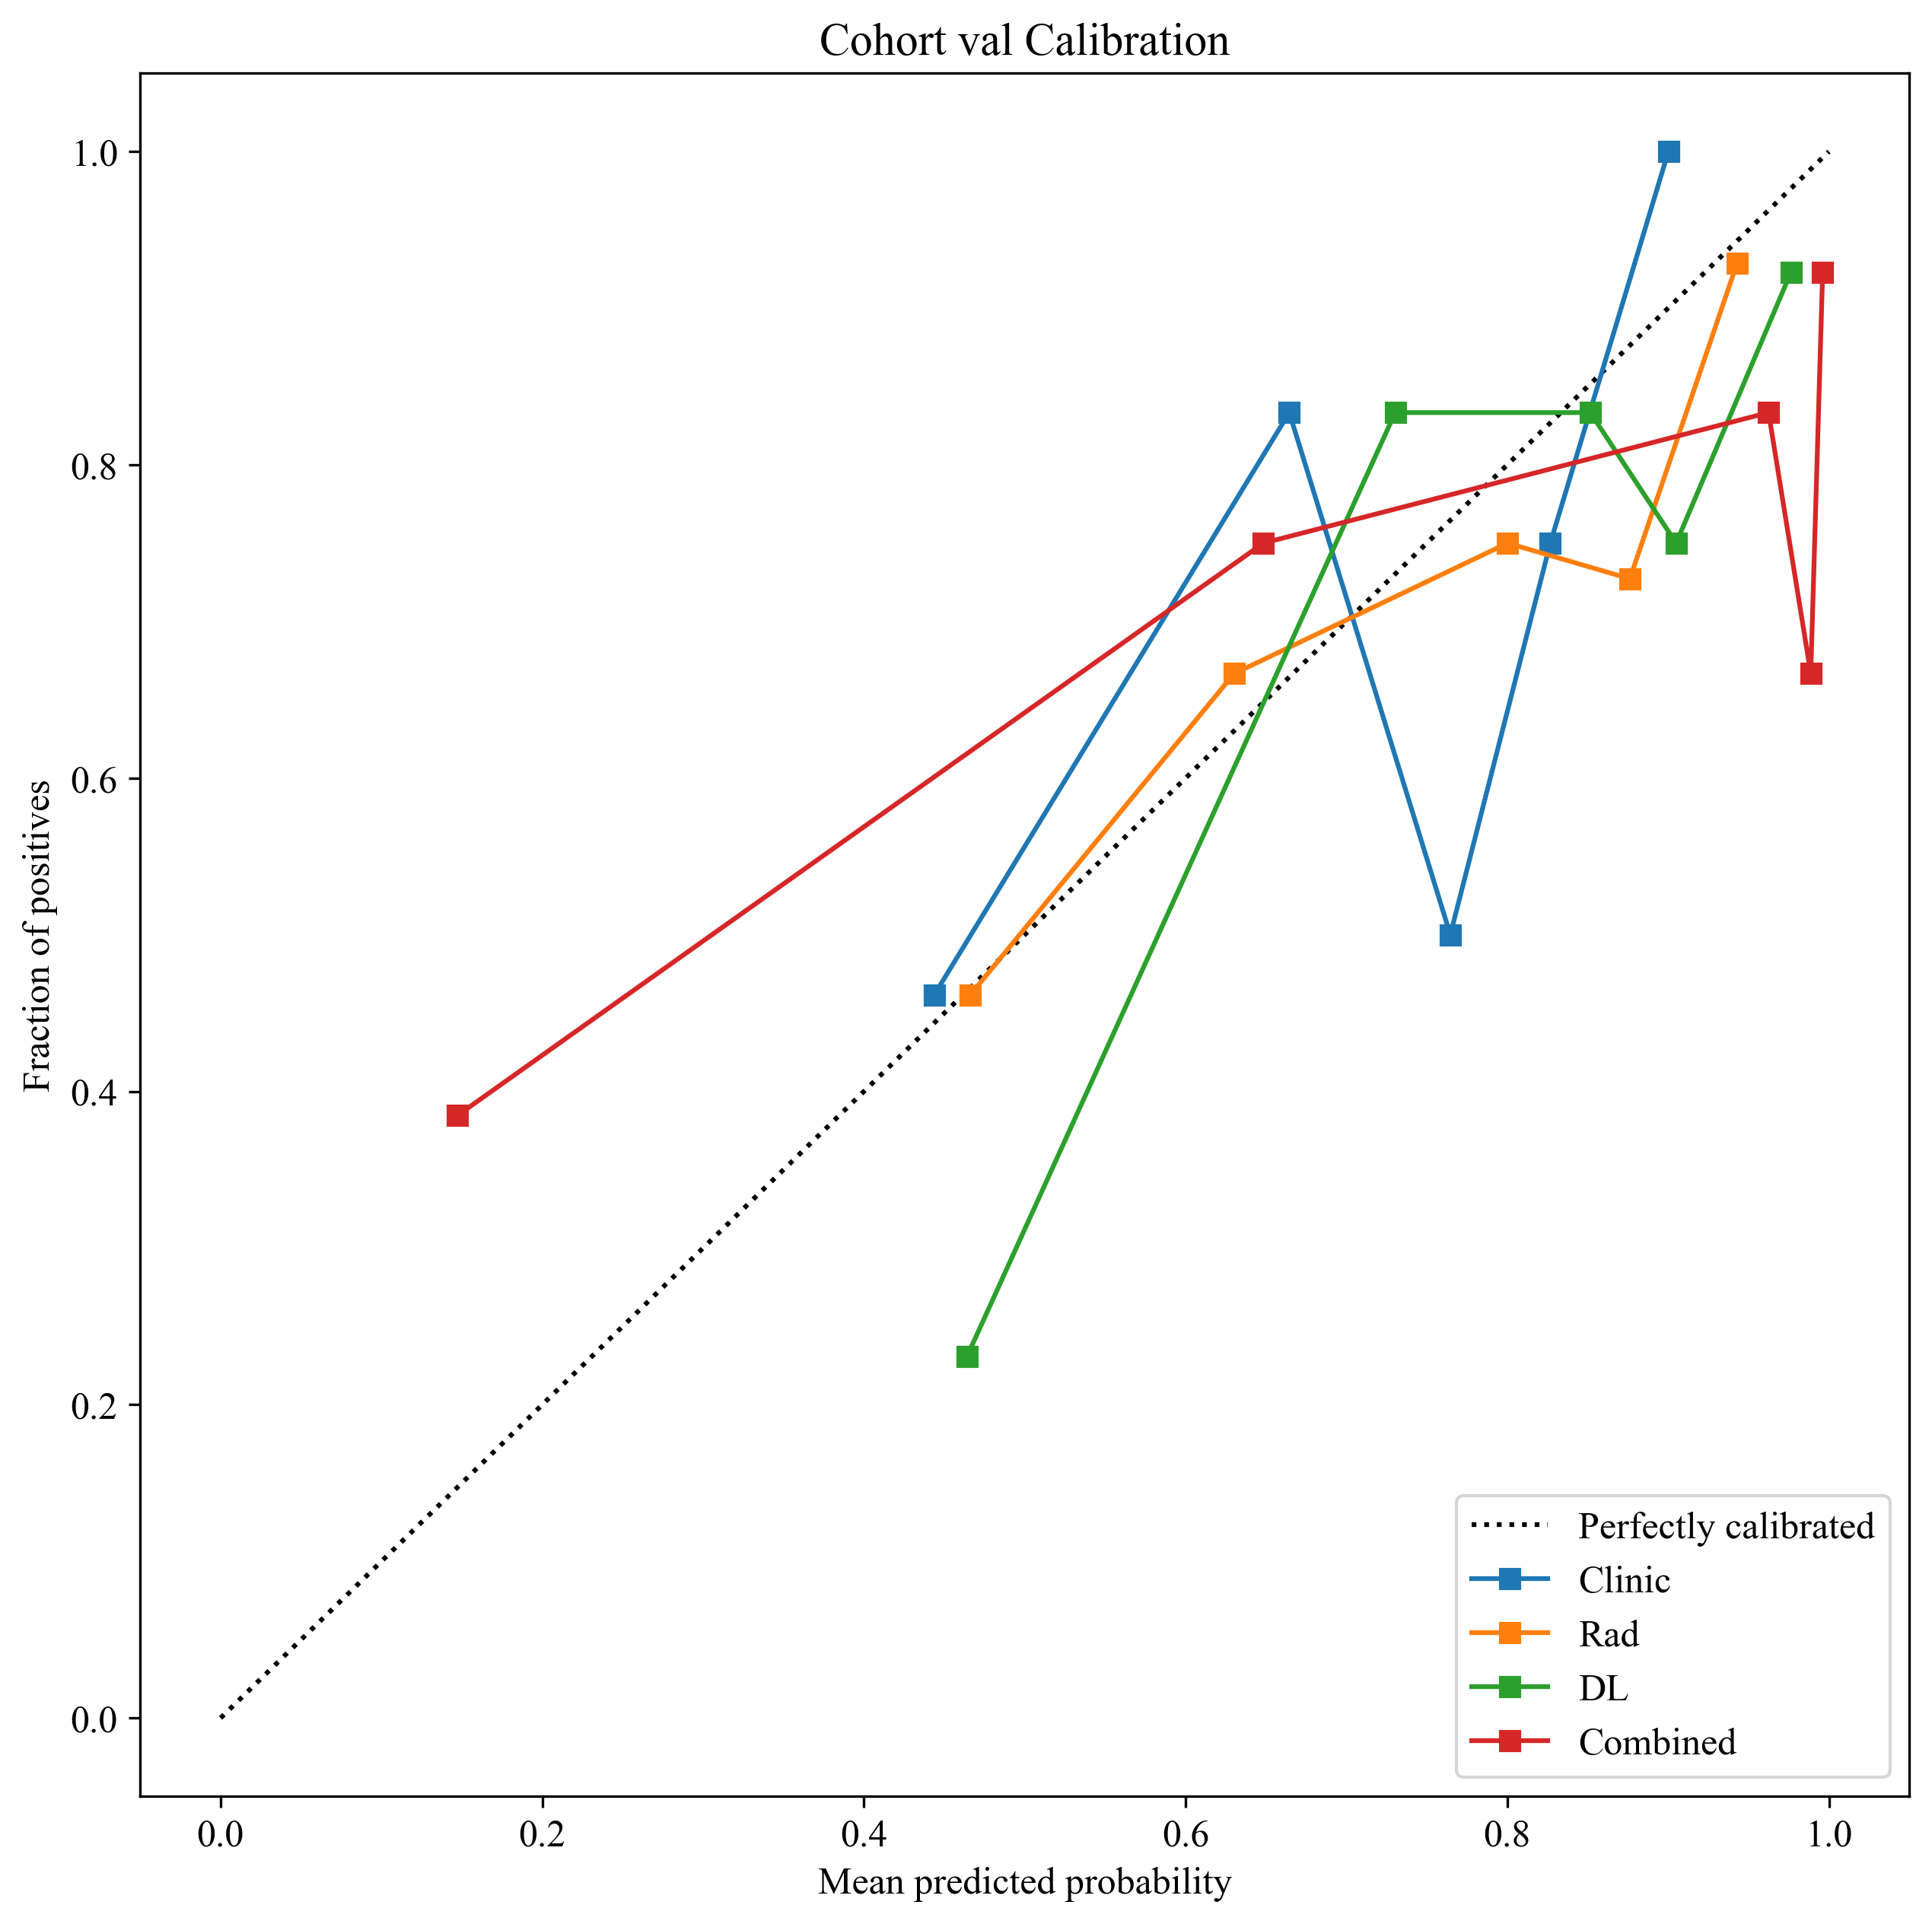

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [2]:
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df, merge_results
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.comp1 import draw_matrix
from onekey_algo.custom.components.metrics import NRI, IDI
from onekey_algo.custom.components.comp1 import plot_DCA
from onekey_algo.custom.components.comp1 import draw_calibration
from onekey_algo.custom.components import stats
from onekey_algo.custom.components.metrics import analysis_pred_binary
from onekey_algo.custom.components import nomogram

hosmer = []
youden = {}
metric = []
fig_size = (5, 4)
for subset in [s for s in get_param_in_cwd('subsets', ['val', 'test'])]:
    ALL_results = None
    for mn in  model_names[:-1]:
        r = pd.read_csv(f"./results/{mn}_{sel_m[mn]}_{subset if subset == 'train' else 'test'}.csv")
        r['ID'] = r['ID'].map(lambda x: os.path.basename(x).replace('.png', '.gz'))
        r.columns = ['ID', '-0', mn]
        if ALL_results is None:
            ALL_results = r
        else:
            ALL_results = pd.merge(ALL_results, r, on='ID', how='inner')
    Clinic = pd.read_csv('data/clinic_sel.csv')
    cnames = [c for c in Clinic.columns if c not in ['ID', 'group', 'label']]
    ALL_results =merge_results(ALL_results, Clinic[['ID'] + cnames], label_data[label_data[group_info] == subset], label_col='ID')
#     ALL_results = normalize_df(ALL_results, not_norm=['ID', 'label'])
    ALL_results = ALL_results.dropna(axis=1)
#     display(ALL_results)
    
    # 计算Nomogram
    data_x = ALL_results[cnames + get_param_in_cwd('fusion_models')]
#     data_x = ALL_results[list(Clinic.columns[1:]) + [model_names[2]]]
    data_y = ALL_results[task]
    if subset == 'train':
        model = LogisticRegression(random_state=0, penalty='none')
        # model = SVC(probability=True, random_state=0)
        model.fit(data_x, data_y)
    results = model.predict_proba(data_x)
    results = pd.DataFrame(results, index=ALL_results['ID'], columns=[f'{task}-0', f'{task}-1']).reset_index()
    results.to_csv(f'./results/Nomo_{subset}.csv', index=False, header=True)
    
    # 绘制整体的ROC曲线
    pred_column = [f'{task}-0', f'{task}-1']
    Nomo_results = pd.read_csv(f'./results/Nomo_{subset}.csv', header=0)
    Nomo_results.columns = ['ID', 'label-9', model_names[-1]]
    ALL_results = pd.merge(ALL_results, Nomo_results, on='ID', how='inner')
    gt = [np.array(ALL_results[task]) for _ in model_names]
    pred_train = [np.array(ALL_results[d]) for d in model_names]
    okcomp.comp1.draw_roc(gt, pred_train, labels=model_names, title=f'Cohort {subset} ROC', auto_point=False)
    plt.savefig(f'img/{subset}_auc.svg')
    plt.show()
    
    # 汇总所有的Metric
    for mname, y, score in zip(model_names, gt, pred_train):
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score)
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        youden[mname] = thres
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, subset))
    metric_ = pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI',
                                                       'Sensitivity', 'Specificity', 
                                                       'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                       'Threshold', 'Cohort'])

    display(metric_)
    
    # 绘制Delong
    delong = []
    delong_columns = []
    this_delong = []
    plt.figure(figsize=fig_size)
    cm = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            if i <= j:
                cm[i][j] = np.nan
            else:
                cm[i][j] = delong_roc_test(ALL_results[task], ALL_results[mni], ALL_results[mnj])[0][0]
    cm = pd.DataFrame(cm[1:, :-1], index=model_names[1:], columns=model_names[:-1])
    draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} Delong')
    plt.savefig(f'img/{subset}_delong.svg', bbox_inches = 'tight')
    plt.show()
    
    # NRI
    delong = []
    delong_columns = []
    this_delong = []
    plt.figure(figsize=fig_size)
    cm = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            cm[i][j] = NRI(ALL_results[mni] > youden[mni], ALL_results[mnj] > youden[mnj], ALL_results[task])
    cm = pd.DataFrame(cm, index=model_names, columns=model_names)
    draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} NRI')
    plt.savefig(f'img/NRI_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()
    
    # IDI
    delong = []
    delong_columns = []
    this_delong = []
    cm = np.zeros((len(model_names), len(model_names)))
    p = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            cm[i][j], p[i][j] = IDI(ALL_results[mni], ALL_results[mnj], ALL_results[task], with_p=True)

    for d, n in zip([cm, p], ['IDI', 'IDI pvalue']):
        plt.figure(figsize=fig_size)
        d = pd.DataFrame(d, index=model_names, columns=model_names)
        draw_matrix(d, annot=True, cmap='jet_r', cbar=True)
        plt.title(f'Cohort {subset} {n}')
        plt.savefig(f'img/{n}_each_cohort_{subset}.svg', bbox_inches = 'tight')
        plt.show()
        
    # DCA
    plot_DCA([ALL_results[model_name] for model_name in model_names], 
             ALL_results[task], title=f'Cohort {subset} DCA', labels=model_names, y_min=-0.15, remap=False)
    plt.savefig(f'img/{subset}_dca.svg')
    plt.show()
    
    # Calibration
    draw_calibration(pred_scores=pred_train, n_bins=5, remap=False,
                     y_test=gt, model_names=model_names)
    plt.title(f'Cohort {subset} Calibration')
    plt.savefig(f'img/{subset}_cali.svg')
    plt.show()
    
    # HLTest
    hosmer.append([stats.hosmer_lemeshow_test(y_true, y_pred, bins=10, remap=True) 
                  for fn, y_true, y_pred in zip(model_names, gt, pred_train)])
    
    if subset == 'train':
        ALL_results = ALL_results.round(decimals=2)
        n = nomogram.risk_nomogram(ALL_results, result=task, save_name='img/nomogram.png',
                                   columns=list(data_x.columns), width=8000, height=5000, 
                                   x_range='0.05,0.15,0.25,0.35,0.5,0.65,0.75,0.85,0.95')
        display(n)
pd.concat([pd.DataFrame(hosmer, columns=model_names), pd.DataFrame(get_param_in_cwd('subsets'), columns=['Cohort'])], axis=1)

In [ ]:
m = pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI',
                                              'Sensitivity', 'Specificity', 
                                              'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                              'Threshold', 'Cohort'])
m[['Signature', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Cohort']].to_csv('results/metrics.csv', index=False)
m